# Preliminary Analysis: MOMA ML Data <a name="top"></a>

### In this notebook:  
- [Setup](#setup)
- [Exploring the Data](#explore)
- [Cluster Visualization](#cluster)
- [Feature Engineering](#featureengineering)
- [Modeling](#modeling)
- [Holdout Test](#holdout)

In [1]:
from platform import python_version
print(python_version())

3.6.12


## Setup <a name="setup"></a>

In [2]:
# no guarantees all of these get used

In [3]:
import os
import pandas as pd
# import pandas_profiling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
from scipy.stats import norm, shapiro, boxcox
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy import stats
import warnings
import string
import time
import json
from itertools import product
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML
from pandas.io.formats.style import Styler
import pipreqs
from collections import Counter
from kneed import KneeLocator
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import silhouette_visualizer
warnings.filterwarnings('ignore')
%matplotlib inline

ModuleNotFoundError: No module named 'pipreqs'

In [ ]:
from scipy.spatial.distance import cdist 
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit, train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss, f1_score, recall_score, classification_report, confusion_matrix, roc_curve, auc,roc_auc_score, make_scorer, precision_score, silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, PowerTransformer, KBinsDiscretizer, QuantileTransformer, FunctionTransformer
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth, OPTICS, AgglomerativeClustering, AffinityPropagation
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
import sklearn.utils
import imblearn
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

<h4>Helper Functions</h4> (some may be obsolete)

In [ ]:
# Transformer objects, unsure of the exact source
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides column selection
    
    Allows to select columns by name from pandas dataframes in scikit-learn
    pipelines.
    
    Parameters
    ----------
    columns : list of str, names of the dataframe columns to select
        Default: [] 
    
    """
    def __init__(self, columns=[]):
        self.columns = columns

    def transform(self, X, **transform_params):
        """ Selects columns of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
            
        Returns
        ----------
        
        trans : pandas DataFrame
            contains selected columns of X      
        """
        trans = X[self.columns].copy() 
        return trans

    def fit(self, X, y=None, **fit_params):
        """ Do nothing function
        
        Parameters
        ----------
        X : pandas DataFrame
        y : default None
                
        
        Returns
        ----------
        self  
        """
        return self
    

class DataFrameFunctionTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer providing imputation or function application
    
    Parameters
    ----------
    impute : Boolean, default False
        
    func : function that acts on an array of the form [n_elements, 1]
        if impute is True, functions must return a float number, otherwise 
        an array of the form [n_elements, 1]
    
    """
    
    def __init__(self, func, impute = False):
        self.func = func
        self.impute = impute
        self.series = pd.Series() 

    def transform(self, X, **transformparams):
        """ Transforms a DataFrame
        
        Parameters
        ----------
        X : DataFrame
            
        Returns
        ----------
        trans : pandas DataFrame
            Transformation of X 
        """
        
        if self.impute:
            trans = pd.DataFrame(X).fillna(self.series).copy()
        else:
            trans = pd.DataFrame(X).apply(self.func).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Fixes the values to impute or does nothing
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
                
        Returns
        ----------
        self  
        """
        
        if self.impute:
            self.series = pd.DataFrame(X).apply(self.func).copy()
        return self
    
    
class DataFrameFeatureUnion(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that unites several DataFrame transformers
    
    Fit several DataFrame transformers and provides a concatenated
    Data Frame
    
    Parameters
    ----------
    list_of_transformers : list of DataFrameTransformers
        
    """ 
    def __init__(self, list_of_transformers):
        self.list_of_transformers = list_of_transformers
        
    def transform(self, X, **transformparamn):
        """ Applies the fitted transformers on a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        concatted :  pandas DataFrame
        
        """
        
        concatted = pd.concat([transformer.transform(X)
                            for transformer in
                            self.fitted_transformers_], axis=1).copy()
        return concatted


    def fit(self, X, y=None, **fitparams):
        """ Fits several DataFrame Transformers
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
        
        Returns
        ----------
        self : object
        """
        
        self.fitted_transformers_ = []
        for transformer in self.list_of_transformers:
            fitted_trans = clone(transformer).fit(X, y=None, **fitparams)
            self.fitted_transformers_.append(fitted_trans)
        return self


class DropAllZeroTrainColumnsTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides dropping all-zero columns
    """

    def transform(self, X, **transformparams):
        """ Drops certain all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        
        Returns
        ----------
        trans : DataFrame
        """
        
        trans = X.drop(self.cols_, axis=1).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Determines the all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        y : not used
        
        Returns
        ----------
        self : object
        """
        
        self.cols_ = X.columns[(X==0).all()]
        return self

In [ ]:
def get_key(dictonary,val):
    for key, value in dictonary.items():
         if val == value:
             return key
    return "key doesn't exist"

In [ ]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

In [ ]:
class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [4]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# this function takes a dataframe as input and
# returns a modified version thereof
def normalize_spectrum(input_df):
    input_df = input_df.iloc[:,:2001].apply(lambda x: x/x.max(), axis=1)
    return input_df

In [5]:
def evaluate_models(models, X_train, y_train, num_folds,scoring,n_cores):
    results = []
    names = []
    first = True
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_cores,return_train_score=True)
        results.append(cv_results)
        names.append(name)

        # Store results in dataframe
        if first:
            first = False
            add_columns = list((cv_results.keys()))
            results_df = pd.DataFrame(columns=add_columns)
        results_df.loc[len(results_df), 'Model'] = name
        row_idx = results_df.index[results_df['Model'] == name]

        for result in cv_results.keys():
            results_df.loc[row_idx, result] = cv_results[result].mean()

    results_df = results_df.reindex(sorted(results_df.columns), axis=1)
    
    return results_df

In [6]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "8pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

In [7]:
def model_score_display(df,color_palette):
    # Format the results
    cmap = sns.color_palette(color_palette, as_cmap=True)
    p_t = df.copy(deep=True).transpose()

    new_header = p_t.iloc[0] #grab the first row for the header
    p_t = p_t[1:] #take the data less the header row
    p_t.columns = new_header #set the header row as the df header

    return p_t.apply(pd.to_numeric).style.background_gradient(cmap=cmap,axis=1).set_precision(3)

<h4>Load the Data</h4>

In [8]:
# Load dataset into pandas dataframe
full_df = pd.read_csv('full_ml_data.csv')
full_df.name = "Full Dataset"

In [9]:
# Drop mcalDefault because it contains the same value for all observations i.e. not predictive
print("Unique values of mcalDefault",full_df['mcalDefault'].value_counts())
full_df.drop('mcalDefault', axis=1, inplace=True)

Unique values of mcalDefault 1    26685
Name: mcalDefault, dtype: int64


In [10]:
# Drop USID because it may lead to data leakage and would not be applicable at prediction time
print("Number of unique values of USID:",full_df['USID'].nunique())
full_df.drop('USID', axis=1, inplace=True)

Number of unique values of USID: 26685


In [11]:
# Metadata features
meta_df = full_df.iloc[:,2001:]

# Encode target labels
le = preprocessing.LabelEncoder()
meta_df['category_label'] = le.fit_transform(meta_df['category_label'])
category_map = dict(zip(le.classes_, le.transform(le.classes_)))
meta_df['sample_label'] = le.fit_transform(meta_df['sample_label'])
sample_map = dict(zip(le.classes_, le.transform(le.classes_)))

NameError: name 'preprocessing' is not defined

# Exploratory Data Analysis<a name="explore"></a>

<h4>Feature Overview</h4>
<ul>
<li><mark>Laser_Energy</mark>
<li><mark>Laser_Shots</mark> is this actually laser bursts?
<li><mark>Laser_StdDev</mark>
<li><mark>Phase</mark>
<li><mark>TIC</mark> is the Total Ion Count which is the sum of all counts in a mass spectrum.
<li><mark>Max_Bin_Counts</mark>
<li><mark>Charge_Control</mark>
</ul>

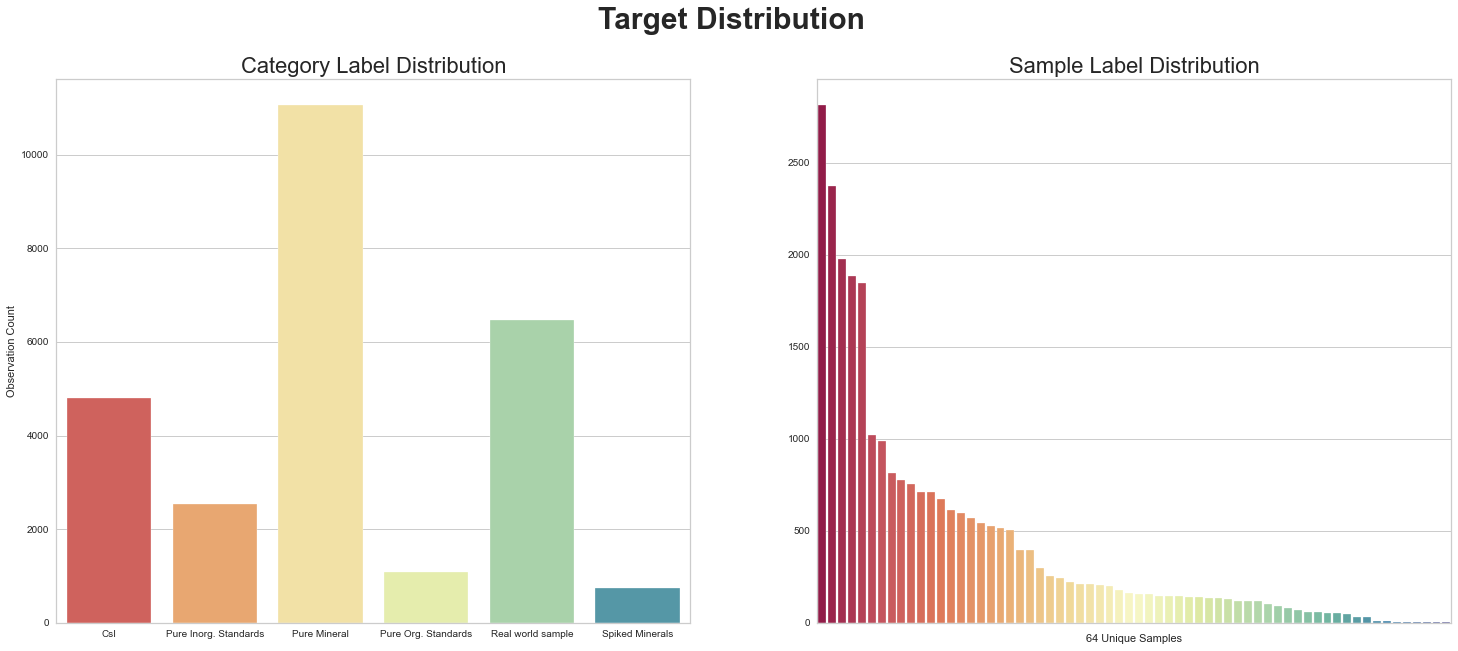

In [28]:
# Plot target distribution
palette = 'Spectral'
fig, axes = plt.subplots(1,2, figsize=(25,10))
cat_plot = sns.countplot(full_df['category_label'], ax=axes[0], palette=palette)
cat_plot.set_title("Category Label Distribution",fontsize=22)
cat_plot.set(xlabel=None)
cat_plot.set(ylabel="Observation Count")

sample_plot = sns.countplot(full_df['sample_label'], ax=axes[1], order = full_df['sample_label'].value_counts().index,palette=palette)
sample_plot.set_title("Sample Label Distribution",fontsize=22)
axes[1].set_xticklabels(labels='')
sample_plot.set(xlabel='64 Unique Samples')
sample_plot.set(ylabel=None)

fig.suptitle("Target Distribution", fontsize=30,fontweight='bold')
fig.show()

<p align=”justify”>The target class labels are imbalanced which must be accounted for either at the data or algorithmic level before training. Data level approaches are typically accomplished with resampling techniques such as Random Under-Sampling, Random Over-Sampling, Cluster-Based Over Sampling, Synthetic Minority Over-sampling Technique (SMOTE), Modified synthetic minority oversampling technique (MSMOTE). Existing classification algorithms can also be modified to make them appropriate for balanced data sets and tend to fall into Bagging-Based or Boosting-Based techniques.

## Feature Correlations

In [65]:
# Calculating feature correlations
df_full_corr = meta_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_full_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_full_corr.drop(df_full_corr.iloc[1::2].index, inplace=True)
df_full_corr_nd = df_full_corr.drop(df_full_corr[df_full_corr['Correlation Coefficient'] == 1.0].index)

corr = df_full_corr_nd['Correlation Coefficient'] > 0.1
df_full_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
10,Laser_StdDev,Laser_Energy,0.602632
12,Max_Bin_Counts,category_label,0.388085
14,Max_Bin_Counts,sample_label,0.381963
16,sample_label,Phase,0.288123
18,Laser_StdDev,Laser_Shots,0.278570
20,Phase,Charge_Control,0.275868
22,TIC,Laser_Energy,0.253852
24,Laser_StdDev,sample_label,0.240767
26,Laser_Shots,Phase,0.212560
28,category_label,Laser_Shots,0.210132


The features are highly correlated and dependent on each other, there are 21 correlations in the entire dataset that are higher than <b>.01</b>. All metadata features are included in this list which indicates they are predictive and should not be dropped. Laser_Energy and Laster_StdDev display the highest correlation which makes intuitive sense. 

Features with high correlation to be dropped: []


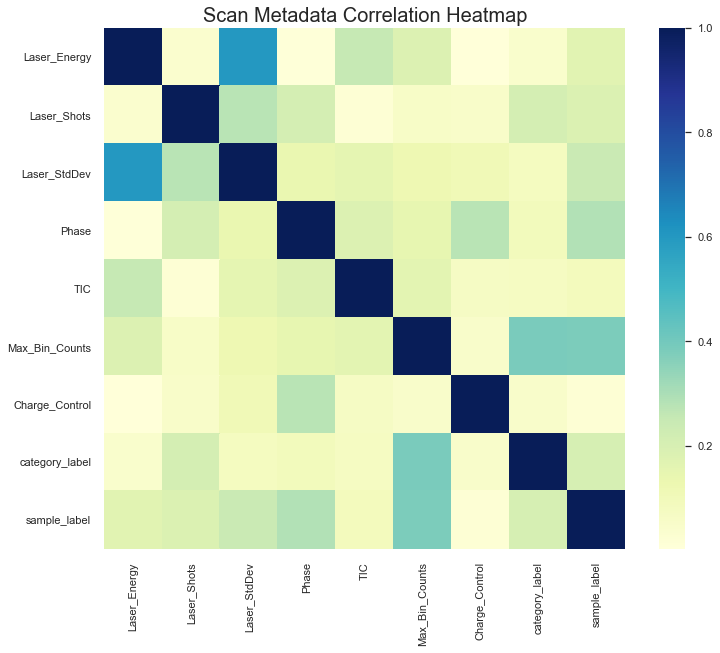

In [66]:
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix

corr_matrix = meta_df.corr(method='pearson').abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.title("Scan Metadata Correlation Heatmap", fontsize=20)
# plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print("Features with high correlation to be dropped:",to_drop)

## Target Distributions

<h4>Mass Spectrum Features</h4>

In [12]:
mass_spec_df = full_df.iloc[:,:2001]

In [68]:
mass_spec_df['Num_Unique_Masses'] = mass_spec_df.astype(bool).sum(axis=1)

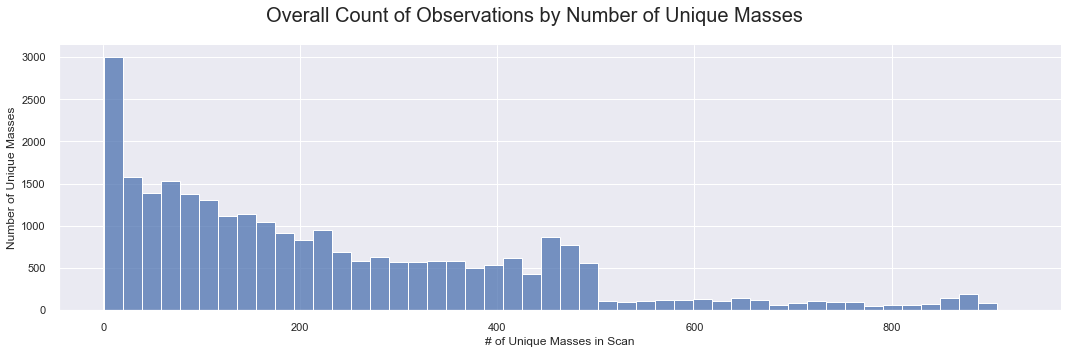

In [69]:
mass_dist = mass_spec_df.append(full_df.iloc[:,2008:])
ax = sns.displot(data=mass_dist,x='Num_Unique_Masses',aspect=3/1)
ax.set(xlabel="# of Unique Masses in Scan",ylabel="Number of Unique Masses")
plt.suptitle("Overall Count of Observations by Number of Unique Masses", fontsize=20)
plt.tight_layout()
plt.show()

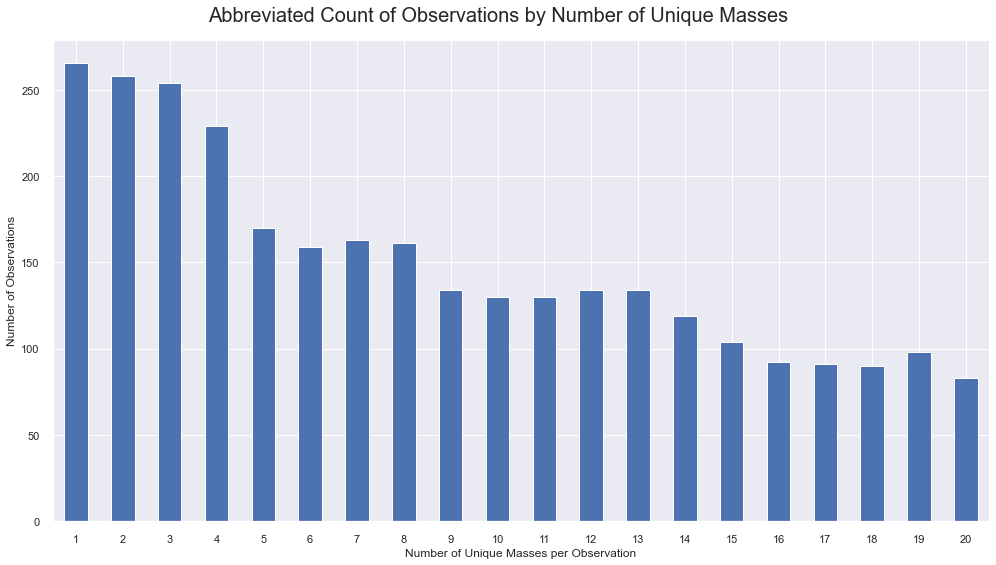

In [70]:
unique_mass_df = pd.DataFrame(columns=['Num_Unique_Masses','Count_Unique_Masses'])
for count in range(1,21):
    unique_mass_df=unique_mass_df.append({"Num_Unique_Masses":count,"Count_Unique_Masses":mass_spec_df[mass_spec_df['Num_Unique_Masses'] == count].count()[0]},ignore_index=True)

fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)
unique_mass_df.plot(kind='bar',x='Num_Unique_Masses',y='Count_Unique_Masses',ax=ax)
ax.get_legend().remove()
plt.suptitle("Abbreviated Count of Observations by Number of Unique Masses", fontsize=20)
plt.xlabel('Number of Unique Masses per Observation')
plt.xticks(rotation=0)
plt.ylabel('Number of Observations')
plt.tight_layout()
plt.show()

Open Question: How many unique masses are expected in scans on Mars? Does the way a sample is processed impact this number?

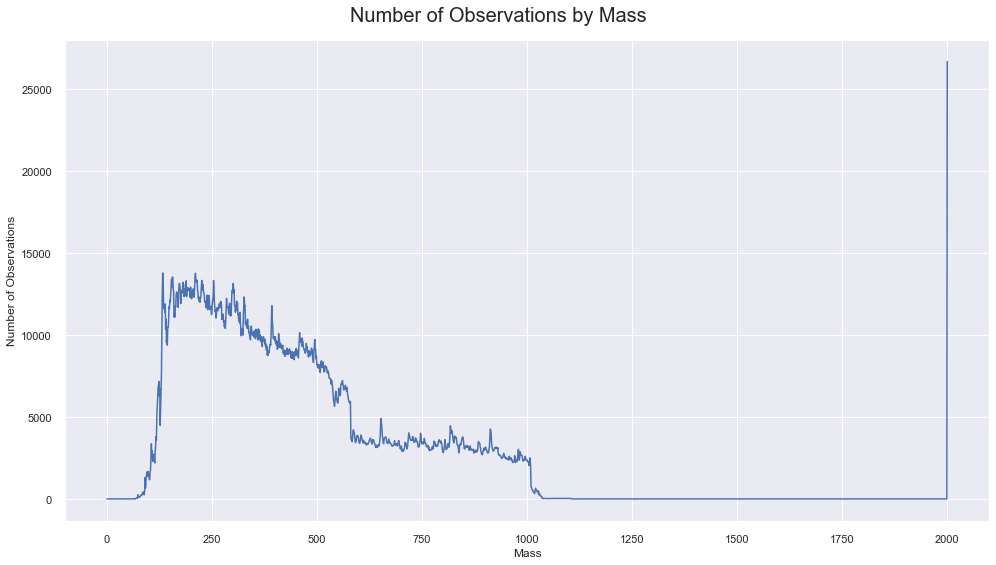

In [71]:
fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)

mass_spec_df.astype(bool).sum(axis=0).plot(ax=ax)
plt.suptitle("Number of Observations by Mass",fontsize=20)
plt.xlabel('Mass')
plt.ylabel('Number of Observations')
plt.tight_layout()
plt.show()

Open Question: How likely is it to encounter masses higher than ~1000 in operation on Mars? The ability to make a prediction outside of this range is nil.

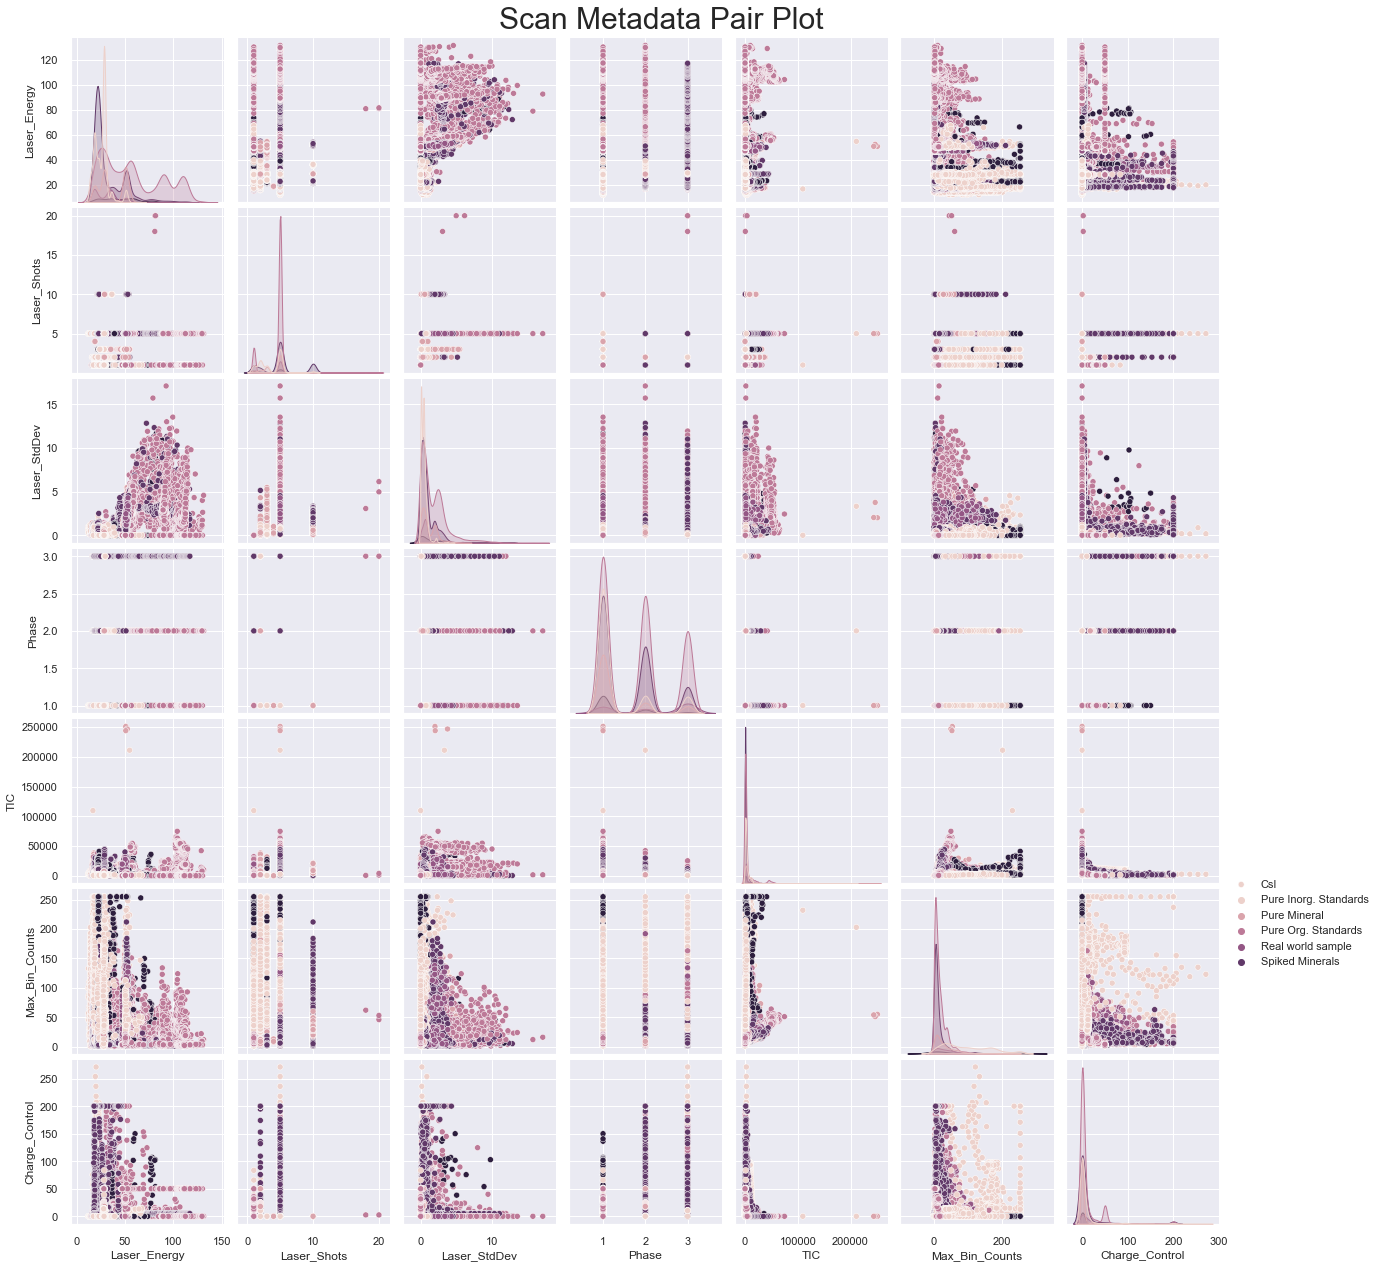

In [72]:
# Plot pairplot for metadata. Harder to interpret but useful to see
g = sns.pairplot(meta_df.drop('sample_label',axis=1), hue="category_label")
g._legend.remove()
plt.suptitle("Scan Metadata Pair Plot", fontsize=30,  y=1.01)
# Grab category names from dict
handles = []
for k,v in category_map.items(): handles.append(k)
plt.legend(handles, loc=(1.04,0.5))
plt.show()

The pairplots exclude <mark>sample_label</mark> and are colored by <mark>category_label</mark>. One thing that jumps out is the apparent frequency of outliers that warrants further inspection (<mark>TIC</mark> and <mark>Laser_Shots</mark> in particular).

In [73]:
# Calculate metadata skewness
meta_skew = meta_df.drop(['category_label','sample_label'],axis=1).skew(axis=0).sort_values(ascending=False)
print(meta_skew)

TIC               6.952662
Charge_Control    4.779839
Laser_StdDev      2.609113
Max_Bin_Counts    2.394025
Laser_Energy      1.319292
Phase             0.801267
Laser_Shots       0.353567
dtype: float64


A positive skewness value indicates an asymmetry in the distribution where the tail is larger towards the right side of the distribution, confirmed visually in the previous step. 

In [74]:
# Calculate meta data Kurtosis
meta_kurtosis = meta_df.drop(['category_label','sample_label'],axis=1).kurt(axis=0).sort_values(ascending=False)
print(meta_kurtosis)

TIC               112.585392
Charge_Control     25.530716
Laser_StdDev        9.628009
Max_Bin_Counts      5.711859
Laser_Shots         1.954763
Laser_Energy        0.859345
Phase              -0.850403
dtype: float64


Only <mark>Laster_Shots</mark> is close to mesokurtic, the rest of the features are leptokrutic, some highly, or platykurtic. These features need to be transformed towards a normal distribution.

In [75]:
# Compute the Shapiro Wilk test to reaffirm what we already know about these meta data features. We could also consider the 
# Kolmogorov-Smirnov test but that seems like overkill at this point
shapiro_df = pd.DataFrame(columns=['Feature','W-statistic','P-value'])
for col in ['Laser_Energy', 'Laser_StdDev', 'TIC', 'Max_Bin_Counts','Charge_Control']:
    shapiro_df=shapiro_df.append({'Feature':col,'W-statistic':shapiro(meta_df[col])[0],'P-value':shapiro(meta_df[col])[1] },ignore_index=True)
shapiro_df  

,Feature,W-statistic,P-value
0,Laser_Energy,0.828255,0.0
1,Laser_StdDev,0.725994,0.0
2,TIC,0.420383,0.0
3,Max_Bin_Counts,0.665113,0.0
4,Charge_Control,0.363722,0.0


Where the p-value is less than the significance level(0.05) then we reject the null hypothesis i.e. the data is significantly different from a normal distribution, which is the case for all features considered here.

<h4>Investigate Nominal Categorical Feature</h4>

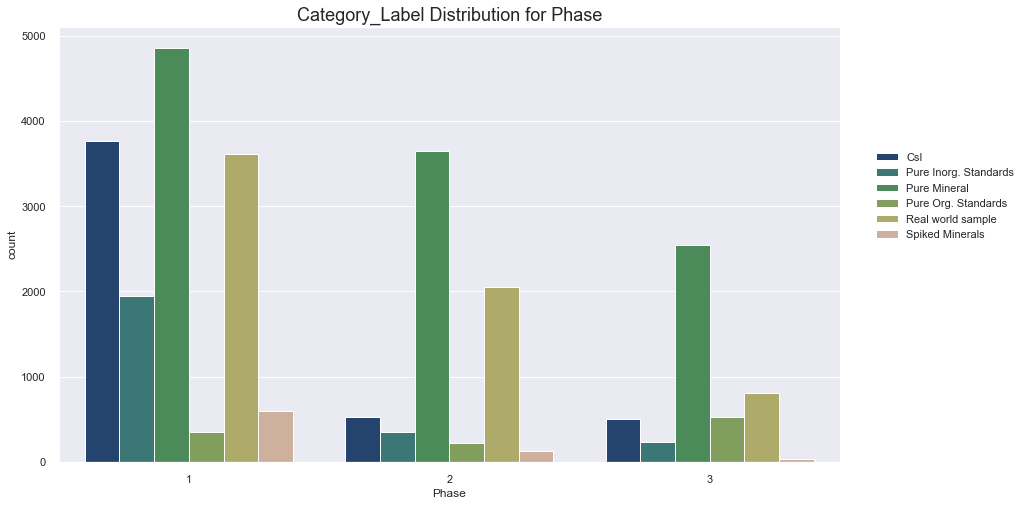

In [76]:
# Plot target distribution across Phase
fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.countplot(data=meta_df, x="Phase", hue="category_label", palette="gist_earth",ax=ax).set_title("Category_Label Distribution for Phase",size=18)
# Grab category names from dict
handles = []
for k,v in category_map.items(): handles.append(k)
plt.legend(handles, loc=(1.04,0.5))
plt.show()

We already knew about the target class imbalance but that fact is bourne out again here. We can also observe an overall decrease in observations as <mark>Phase</mark> increases but the label proportion roughly stays equal. Current understanding is that <mark>Phase</mark> is essentially different sample processing settings and that a 3 is not great than a 2 so we will one-hot encode this feature>

<h4>Investigate Ordinal Feature</h4>

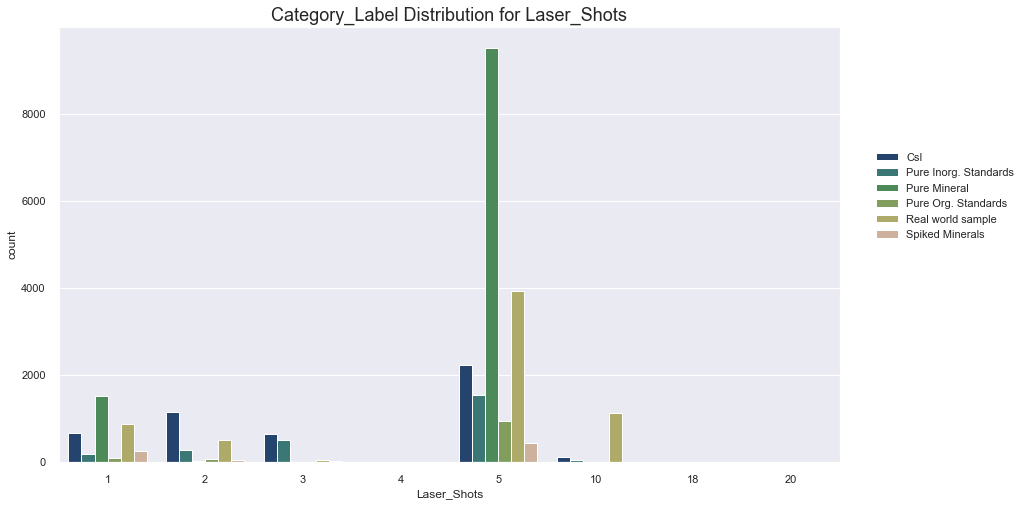

In [77]:
# Plot target distribution across Phase
fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g=sns.countplot(data=meta_df, x="Laser_Shots", hue="category_label", palette="gist_earth",ax=ax).set_title("Category_Label Distribution for Laser_Shots",size=18)
# Grab category names from dict
handles = []
for k,v in category_map.items(): handles.append(k)
plt.legend(handles, loc=(1.04,0.5))
plt.show()

Open Question: Is this distribution representative of expected operations on Mars?
From a pure data perspective 4, 18, 20 are outliers that I would drop because they only constitute 8 observations. I might consider binning but this feature is essentially ordinally encoded by nature.

In [78]:
full_df['Laser_Shots'].value_counts().sort_values()

18        1
20        2
4         5
3      1194
10     1286
2      2032
1      3578
5     18587
Name: Laser_Shots, dtype: int64

# Feature Engineering <a name="featureengineering"></a>

In [79]:
# Use trans_full_df to store transformed data
trans_full_df = full_df.copy()

### Spectrum Features

In [80]:
# Normalize the spectral columns to be between 0 and 1 scaled by the max value in that row
trans_full_df = full_df.iloc[:,:2001].apply(lambda x: x/x.max(), axis=1)

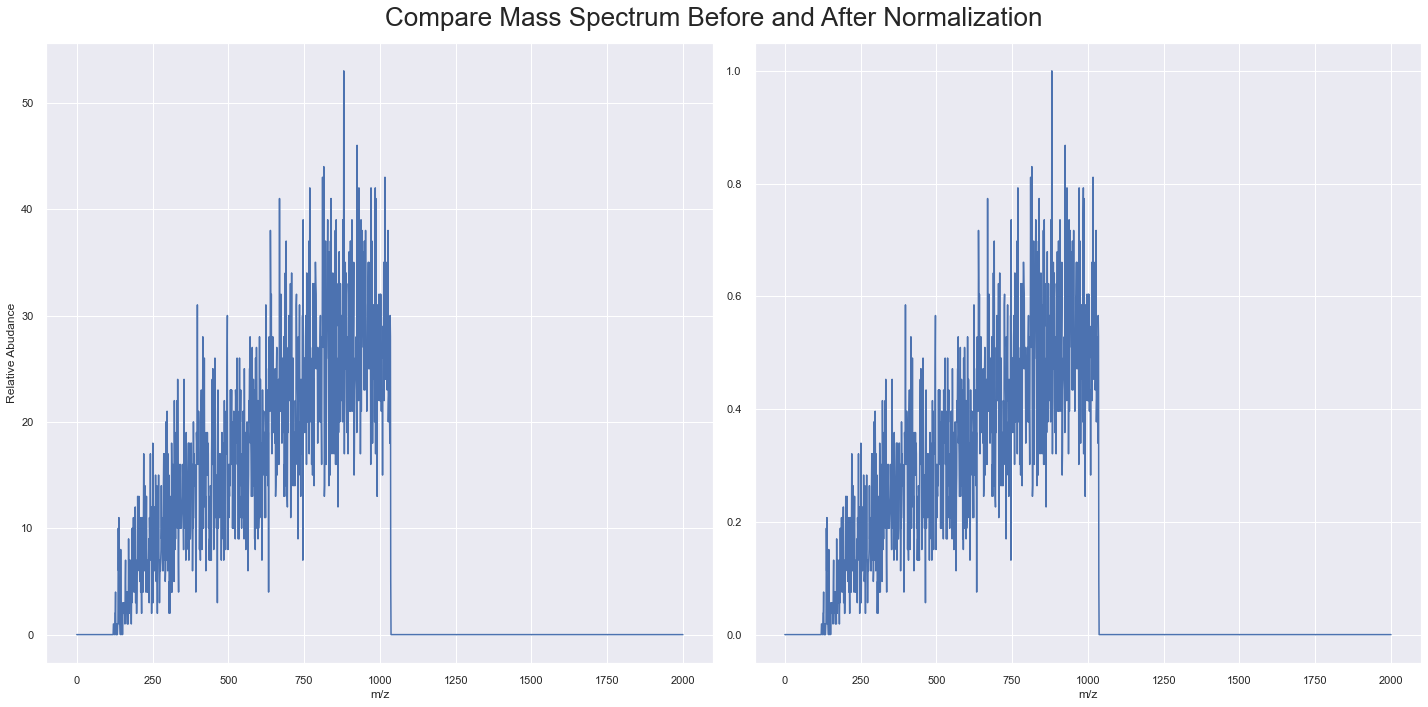

In [81]:
mass_spec_row = 812
fig, axes = plt.subplots(1,2,figsize=(20,10))

plt1 = full_df.iloc[:,:2001].loc[mass_spec_row].plot(ax=axes[0])
plt1.set(ylabel="Relative Abudance",xlabel="m/z")

plt2 = trans_full_df.iloc[:,:2001].loc[mass_spec_row].plot(ax=axes[1])
plt2.set(xlabel="m/z")

fig.suptitle("Compare Mass Spectrum Before and After Normalization",fontsize=26)
fig.tight_layout()
plt.show()

In [82]:
# Unused, alternative way
spectrum_pipeline = make_pipeline(
    SelectColumnsTransformer(full_df.iloc[:,:2001].columns),
    DataFrameFunctionTransformer(func = lambda x: x/x.max())
)

### Continuous Features

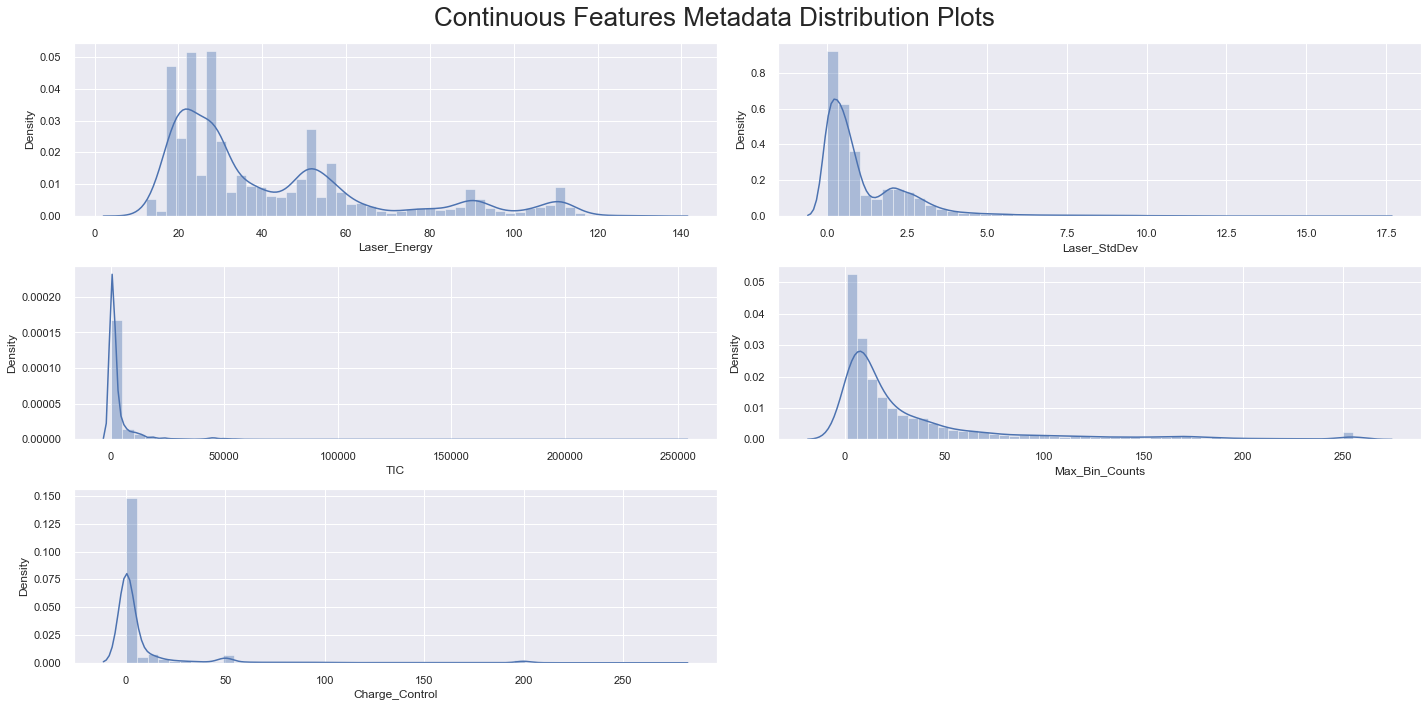

In [83]:
# Plot distributions of the continuous features
continuous_features = ['Laser_Energy', 'Laser_StdDev', 'TIC', 'Max_Bin_Counts','Charge_Control']
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
start = 0
for j in range(3):
    for i in range(2):
        if start == len(continuous_features):
            # Hide last plot since odd total number
            ax[j,i].set_visible(False)
            break
        sns.distplot(meta_df[continuous_features[start]], ax=ax[j, i])
        start += 1
        
fig.suptitle("Continuous Features Metadata Distribution Plots", fontsize=26)
fig.tight_layout()
fig.show()

All features exhibit positive skew which warrants further investigation. The data appears to conform to a power law distribution which usually calls for a log transformation.

Compare a few different transformations

In [84]:
# Apply log transform to continuous features
trans_full_df = full_df[continuous_features].apply(lambda x: np.log1p(x), axis=1)

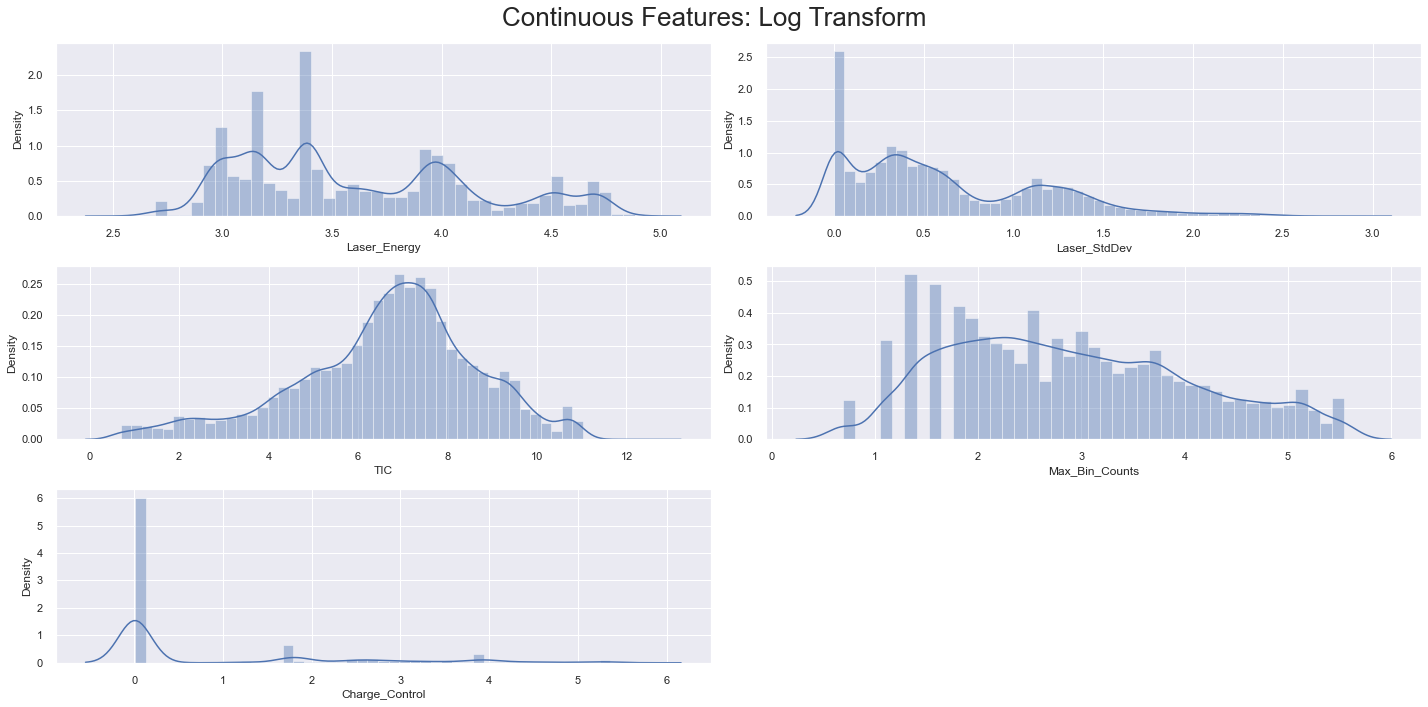

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
start = 0
for j in range(3):
    for i in range(2):
        if start == len(continuous_features):
            # Hide last plot since odd total number
            ax[j,i].set_visible(False)
            break
        sns.distplot(trans_full_df[continuous_features[start]], ax=ax[j, i])
        start += 1
        
fig.suptitle("Continuous Features: Log Transform", fontsize=26)
fig.tight_layout()
fig.show()

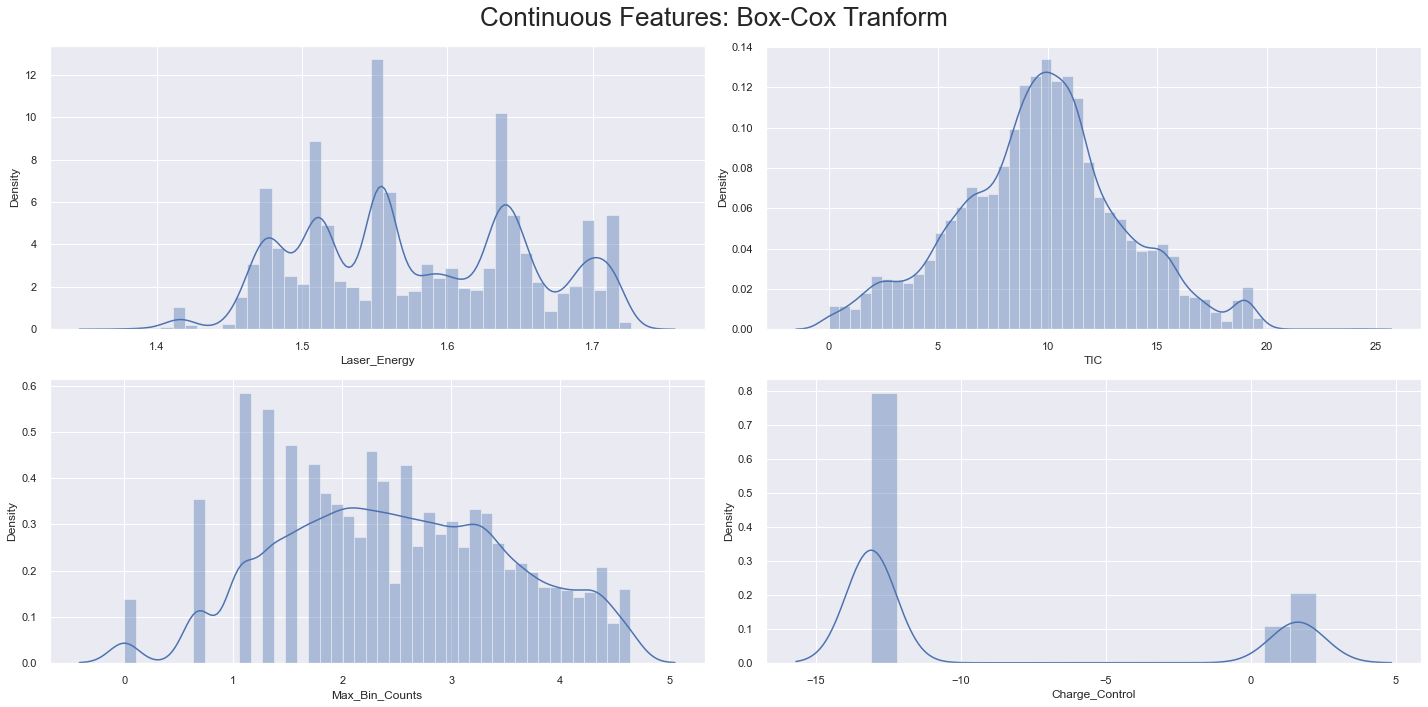

In [86]:
# Apply Box-Cox transformation to continuous features
# negative value issue with Laser_StdDev
bc_features = ['Laser_Energy', 'TIC', 'Max_Bin_Counts', 'Charge_Control']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
start = 0
for j in range(2):
    for i in range(2):
        if start == len(continuous_features):
            # Hide last plot since odd total number
            ax[j,i].set_visible(False)
            break
            
        fitted_data, fitted_lambda = stats.boxcox(full_df[bc_features[start]]) 
        sns.distplot(fitted_data,ax=ax[j, i]) 
        ax[j, i].set(xlabel=bc_features[start])
        start += 1
        
fig.suptitle("Continuous Features: Box-Cox Tranform", fontsize=26)
fig.tight_layout()
fig.show()

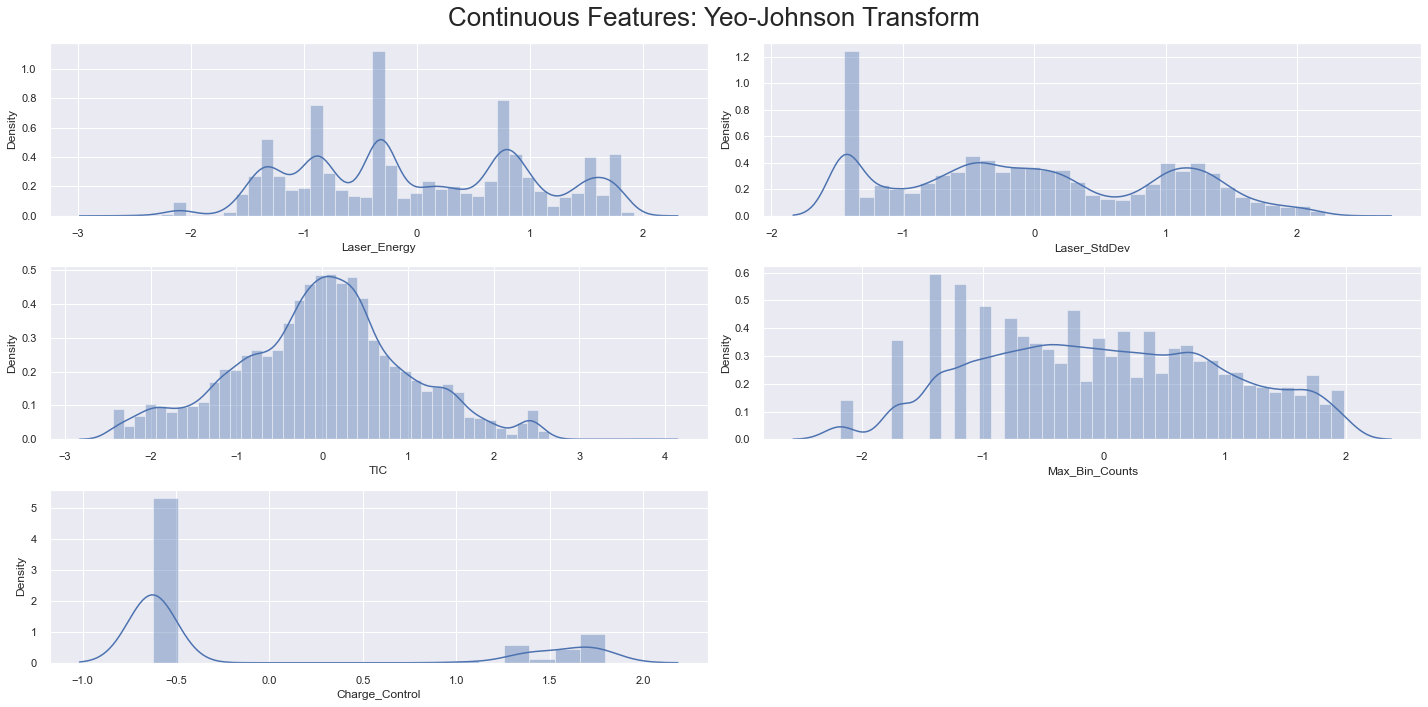

In [87]:
# perform a yeo-johnson transform of the dataset
pt = PowerTransformer(method='yeo-johnson')
data = pt.fit_transform(full_df[continuous_features])
# convert the array back to a dataframe
yj_dataset = pd.DataFrame(data)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
start = 0
for j in range(3):
    for i in range(2):
        if start == len(continuous_features):
            # Hide last plot since odd total number
            ax[j,i].set_visible(False)
            break
        sns.distplot(yj_dataset[start], ax=ax[j, i])
        ax[j, i].set(xlabel=continuous_features[start])
        start += 1
        
fig.suptitle("Continuous Features: Yeo-Johnson Transform", fontsize=26)
fig.tight_layout()
fig.show()

In [ ]:
le_test_df = np.sqrt(full_df['Laser_Energy'])
le_test_df = le_test_df.apply(lambda x: np.log1p(x))

sns.distplot(le_test_df)
plt.show()

<b>Investigate Charge Control

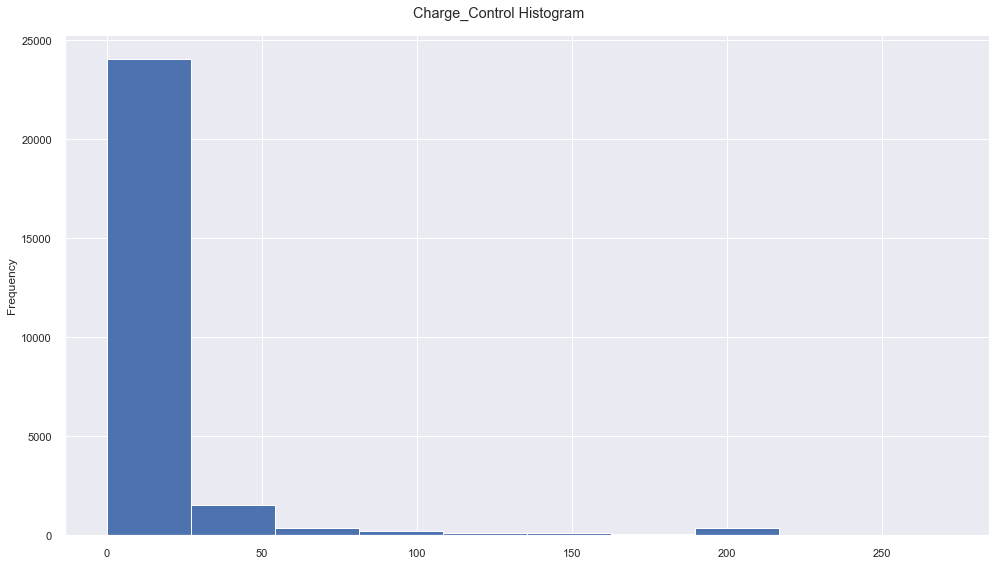

In [89]:
fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)
full_df['Charge_Control'].plot(kind="hist").set(xlabel='')
plt.suptitle("Charge_Control Histogram")
plt.tight_layout()
plt.show()

In [90]:
full_df[full_df['Charge_Control'] < 5].count()

0                 19338
1                 19338
2                 19338
3                 19338
4                 19338
                  ...  
TIC               19338
Max_Bin_Counts    19338
Charge_Control    19338
category_label    19338
sample_label      19338
Length: 2010, dtype: int64

In [91]:
full_df['Charge_Control'].describe()

count    26685.000000
mean         9.553514
std         29.156759
min          0.010000
25%          0.010000
50%          0.010000
75%          5.000000
max        271.130005
Name: Charge_Control, dtype: float64

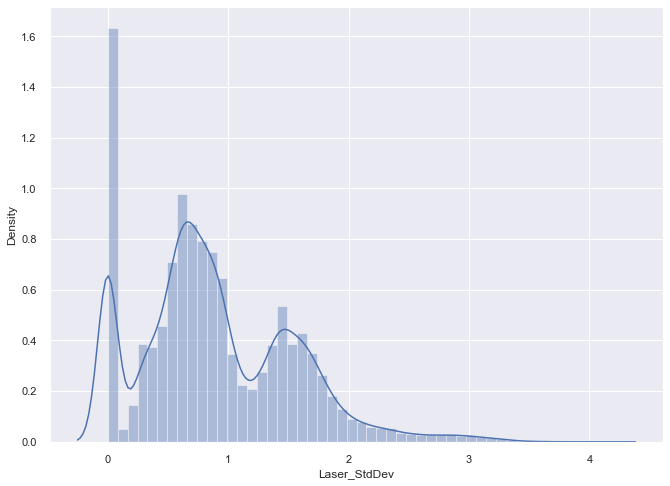

In [92]:
# Apply sqrt transform
cc_df = np.sqrt(full_df['Laser_StdDev'])
sns.distplot(cc_df)
plt.show()

In [124]:
# # Calculate bins from 10 quartiles on full dataset here, in reality only use on training set via pipeline
# cc_bin_test, bins = pd.qcut(full_df['Charge_Control'], q=20, retbins=True,duplicates='drop')
# bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))

# # Visualize these arbitrary bins
# fig, ax = plt.subplots(1, 1, figsize = (15, 10))
# sns.countplot(x=cc_bin_test)
# plt.show()

### Pipelines

In [ ]:
# Manually transform data to confirm operational pipeline
test_trans_df = full_df.copy()
test_trans_df.drop(['category_label','sample_label'],axis=1, inplace=True)

test_trans_df['Laser_StdDev'] = np.sqrt(test_trans_df['Laser_StdDev'])

dum_df = pd.get_dummies(full_df['Phase'])
# test_trans_df = pd.concat([test_trans_df,dum_df],axis=1)
test_trans_df.drop(['Phase'], axis=1, inplace=True)

test_trans_df['TIC'],_ = stats.boxcox(test_trans_df['TIC'])
test_trans_df['Max_Bin_Counts'],_ = stats.boxcox(test_trans_df['Max_Bin_Counts'])

test_trans_df['Charge_Control'] = np.log(test_trans_df['Charge_Control'])
test_trans_df['Laser_Energy'] = np.log(test_trans_df['Laser_Energy'])

test_spec_df = test_trans_df.iloc[:,:2001].apply(lambda x: x/x.max(), axis=1)
# test_trans_df.iloc[:,-9:]

standard_scaler = StandardScaler()
test_scaled_df = pd.DataFrame(standard_scaler.fit_transform(test_trans_df))
test_scaled_df = pd.concat([test_spec_df,test_scaled_df,dum_df],axis=1)
# test_scaled_df

In [12]:
# Create feature pipelines for easier processing
spectrum_preprocessing = Pipeline([
    ('normalize', DataframeFunctionTransformer(normalize_spectrum))
])

laser_std_preprocessing = Pipeline([
    ('sqrt', FunctionTransformer(np.sqrt)),
#     ('kbins7',KBinsDiscretizer(n_bins=7, encode='onehot-dense', strategy='quantile'))
])

phase_preprocessing = Pipeline([
    ('ohe', OneHotEncoder())
])

bc_preprocessing = Pipeline([
    ('bc', PowerTransformer(method='box-cox'))
])

log_preprocessing = Pipeline([
    ('log', FunctionTransformer(np.log)),
])

standardscaler_preprocessing = Pipeline([
    ('standard_scaler', StandardScaler())
])

full_preprocess = ColumnTransformer([
    ('laser_std_preprocessing', laser_std_preprocessing, ['Laser_StdDev']),
    ('bc_preprocessing', bc_preprocessing, ['TIC','Max_Bin_Counts']),
    ('log_preprocessing', log_preprocessing, ['Charge_Control','Laser_Energy']),
    ('passthrough', 'passthrough', ['Laser_Shots']),
#     ('phase_preprocessing', phase_preprocessing, ['Phase']),
#     ("standardize", standardscaler_preprocessing, ['Laser_StdDev','TIC','Max_Bin_Counts','Charge_Control','Laser_Energy','Laser_Shots'])
], remainder='drop')

preprocess_pipeline = Pipeline([
    ('full_preprocess', full_preprocess),
])

In [ ]:
standard_scaler = StandardScaler()

full_test_df = full_df.copy()
dum_df = pd.get_dummies(full_test_df['Phase'])
full_test_df.drop(['category_label','sample_label','Phase'],axis=1, inplace=True)

spectrum_transform_df = spectrum_preprocessing.fit_transform(full_test_df)
meta_transform_df = pd.DataFrame(preprocess_pipeline.fit_transform(full_test_df))
meta_scaled_df = pd.DataFrame(standard_scaler.fit_transform(meta_transform_df))

trans_df = pd.concat([spectrum_transform_df,meta_scaled_df,dum_df],axis=1)

# trans_df

In [ ]:
# trans_df.iloc[:,:2001].loc[0].plot(color="C0")
# test_scaled_df.iloc[:,:2001].loc[0].plot(color="C1")

In [ ]:
# Confirm transformations are as expected
# trans_df.iloc[:,-6:-5].plot(kind='hist')

In [ ]:
# np.log(full_df['Charge_Control']).plot(kind='hist')

## Cluster Analysis <a name="cluster"></a>

In [22]:
# Get data, normalize spectrum and encode phase only before transforming
full_cluster_df = full_df.copy()
full_cluster_df.drop(['category_label','sample_label'],axis=1, inplace=True)
full_spectrum_df = pd.DataFrame(full_cluster_df.iloc[:,:2001].apply(lambda x: x/x.max(), axis=1))

In [23]:
dum_df = pd.get_dummies(full_df['Phase'], prefix='Phase_')
full_cluster_df.drop(['Phase'], axis=1, inplace=True)

standard_scaler = StandardScaler()
full_cluster_scaled = pd.DataFrame(standard_scaler.fit_transform(full_cluster_df[['Laser_StdDev','TIC','Max_Bin_Counts','Charge_Control','Laser_Energy','Laser_Shots']]))
full_cluster_scaled = pd.concat([full_spectrum_df,full_cluster_scaled,dum_df],axis=1)

<AxesSubplot:>

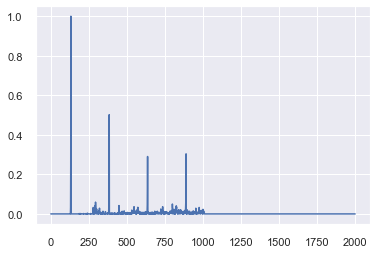

In [24]:
full_cluster_scaled.iloc[:,:2001].loc[0].plot()

In [66]:
# Drop the empty spectrum columns to speed processing
zero_spec = list(range(1107,2001))
full_cluster_scaled_drop = full_cluster_scaled.copy(deep=True)
col = list(full_cluster_scaled_drop.columns)[1107:2000]
full_cluster_scaled_drop.drop(col,axis=1,inplace=True)

In [68]:
# full_cluster_scaled_drop

In [57]:
# full_cluster_scaled

Three popular categories of clustering algorithms are partitional, hierarchical, and density-based and we will apply one technique of each category to explore the data.

<h4>K-Means</h4>

In [95]:
Standard_Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=5)
    Standard_km = km.fit(full_cluster_scaled)
    Standard_Sum_of_squared_distances.append(Standard_km.inertia_)

In [96]:
Full_Standard_Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,n_jobs=5)
    Full_Standard_km = km.fit(trans_df)
    Full_Standard_Sum_of_squared_distances.append(Full_Standard_km.inertia_)

In [97]:
Raw_Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,n_jobs=5)
    Raw_km = km.fit(full_df.drop(['category_label','sample_label'],axis=1))
    Raw_Sum_of_squared_distances.append(Raw_km.inertia_)

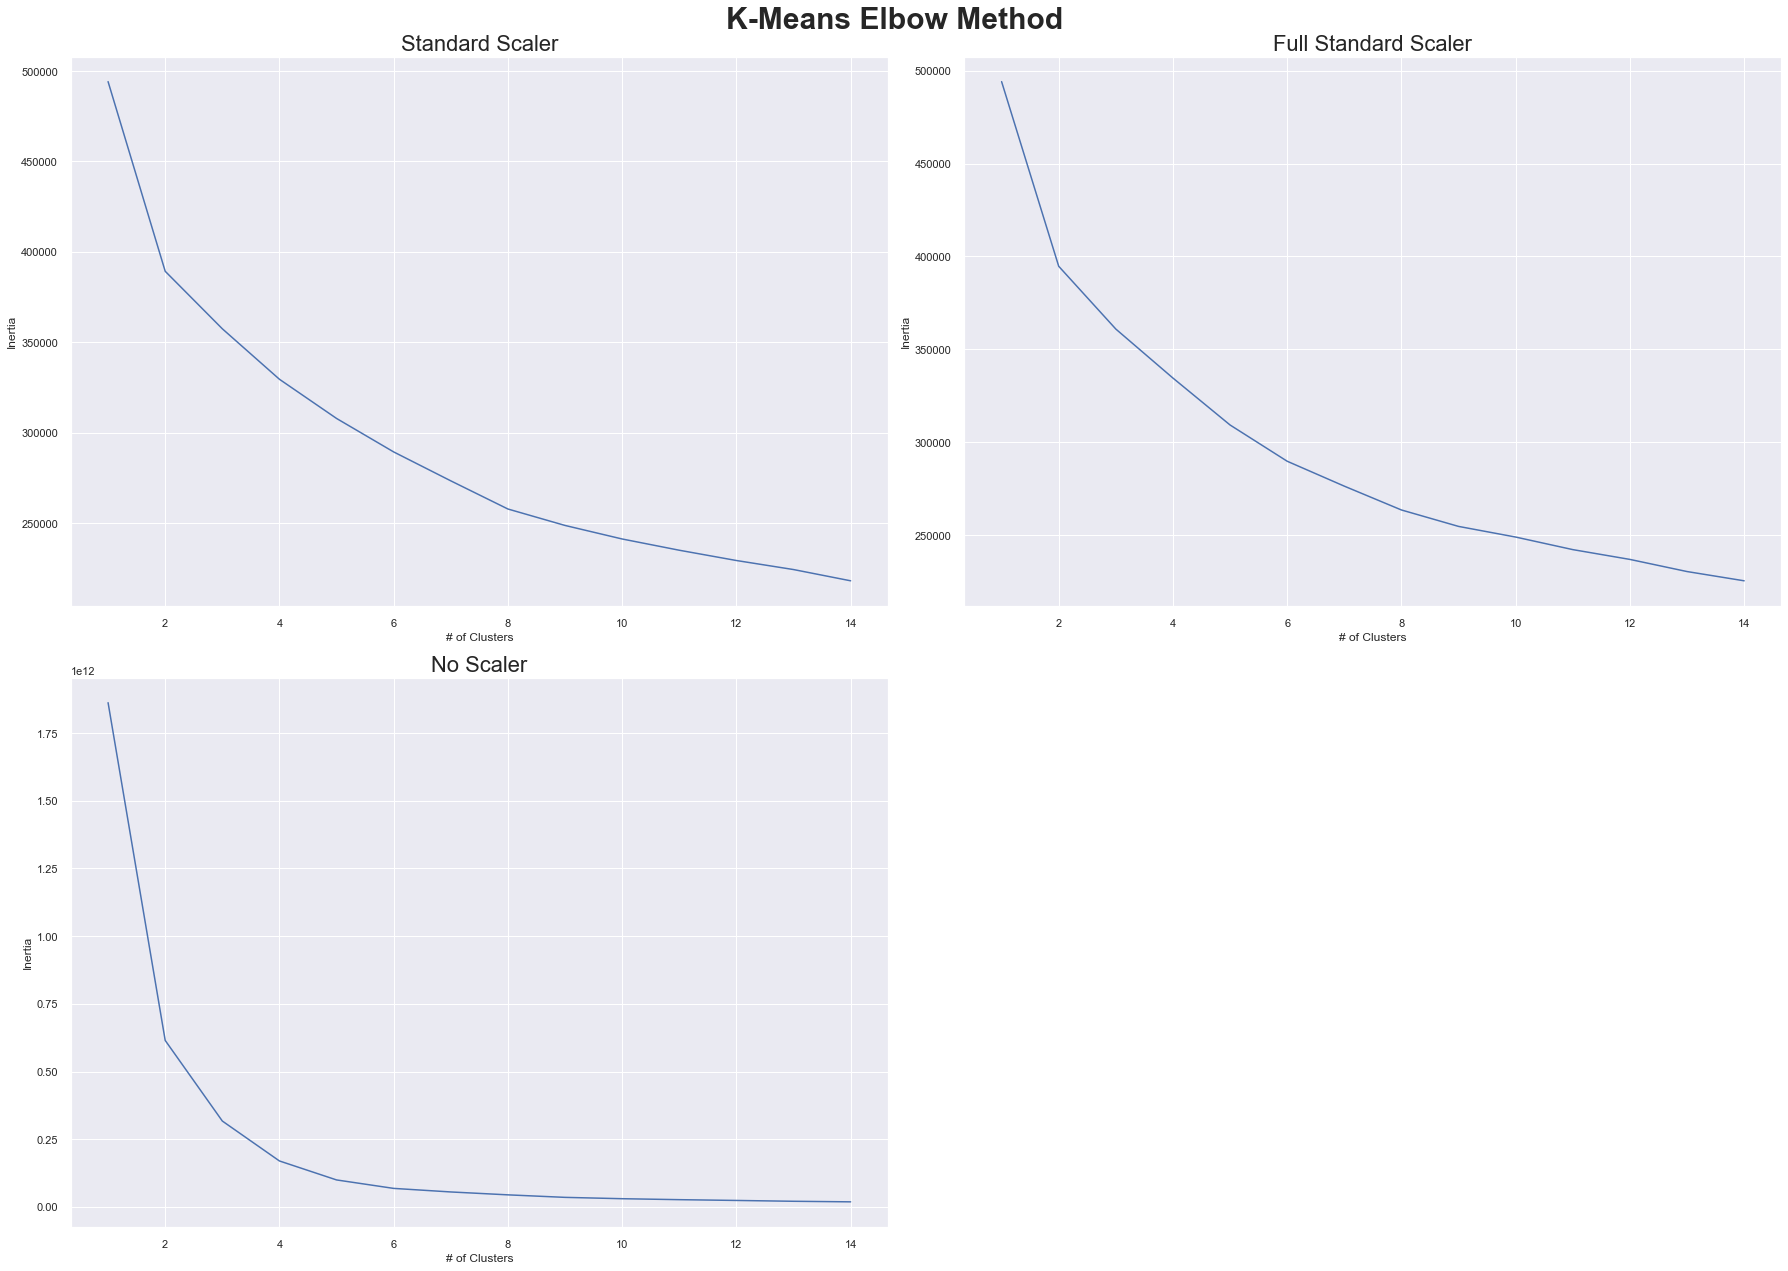

In [98]:
fig, axes = plt.subplots(2,2, figsize=(25,18))

axes[0,0].plot(K, Standard_Sum_of_squared_distances)
axes[0,0].set_title('Standard Scaler',fontsize=22)
axes[0,0].set(xlabel='# of Clusters')
axes[0,0].set(ylabel="Inertia")

axes[0,1].plot(K, Full_Standard_Sum_of_squared_distances)
axes[0,1].set_title('Full Standard Scaler',fontsize=22)
axes[0,1].set(xlabel='# of Clusters')
axes[0,1].set(ylabel="Inertia")

axes[1,0].plot(K, Raw_Sum_of_squared_distances)
axes[1,0].set_title('No Scaler',fontsize=22)
axes[1,0].set(xlabel='# of Clusters')
axes[1,0].set(ylabel="Inertia")

axes[1,1].set_visible(False)

fig.suptitle("K-Means Elbow Method", fontsize=30,fontweight='bold')
fig.tight_layout()
fig.show()

The optimal number of clusters is somewhere between 2 and 8 but it's not entirely clear from this method. K-Means works well with spherical clusters but not clusters of complex shape or clusters of varied density.

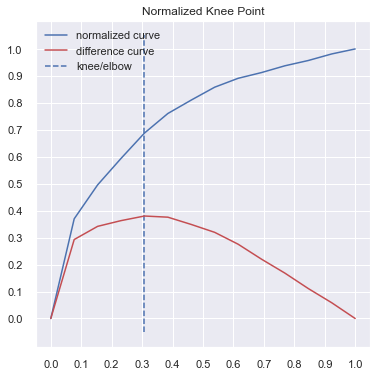

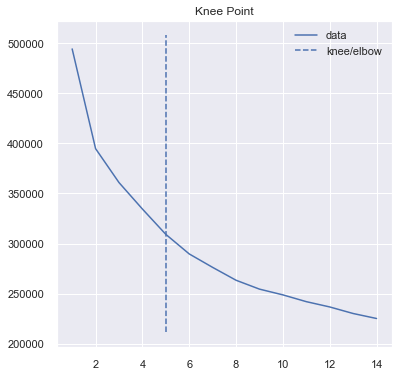

In [99]:
# Use Kneed library to calculate the elbow
kneedle = KneeLocator(K, Full_Standard_Sum_of_squared_distances, S=1.0, curve="convex", direction="decreasing")
# Normalized data, normalized knee, and normalized distance curve.
kneedle.plot_knee_normalized()
kneedle.plot_knee()

Rather than visually guesstimating from a graph, applying a quantitative method to find the elbow suggests that there are 5 clusters.

In [100]:
# Use Silhouette analysis and KMeans algorithm to find the ideal number of clusters
# range_n_clusters = list(range(2,19))
range_n_clusters = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(trans_df)
    
    silhouette_avg = silhouette_score(trans_df, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(trans_df, cluster_labels)

# full_cluster_scaled
# For n_clusters = 2 The average silhouette_score is : 0.4996635175168593
# For n_clusters = 3 The average silhouette_score is : 0.3311326843455243
# For n_clusters = 4 The average silhouette_score is : 0.11312249863612003
# For n_clusters = 5 The average silhouette_score is : 0.11105867471114125
# For n_clusters = 6 The average silhouette_score is : 0.1127984460034759
# For n_clusters = 7 The average silhouette_score is : 0.1274419363082179
# For n_clusters = 8 The average silhouette_score is : 0.13769381935926603
# For n_clusters = 9 The average silhouette_score is : 0.15188104685291515
# For n_clusters = 10 The average silhouette_score is : 0.14332949775240714
# For n_clusters = 11 The average silhouette_score is : 0.1321386494000135
# For n_clusters = 12 The average silhouette_score is : 0.13487439651197858
# For n_clusters = 13 The average silhouette_score is : 0.12895183317132639
# For n_clusters = 14 The average silhouette_score is : 0.13229963657267707
# For n_clusters = 15 The average silhouette_score is : 0.1279213874981626
# For n_clusters = 16 The average silhouette_score is : 0.12597916026380715
# For n_clusters = 17 The average silhouette_score is : 0.12541804762459263
# For n_clusters = 18 The average silhouette_score is : 0.12727123733679668

#
# full_transform_scaled
# For n_clusters = 2 The average silhouette_score is : 0.4443893206860661
# For n_clusters = 3 The average silhouette_score is : 0.112265986289102
# For n_clusters = 4 The average silhouette_score is : 0.11667043815746034
# For n_clusters = 5 The average silhouette_score is : 0.12845333820899374
# For n_clusters = 6 The average silhouette_score is : 0.13588866572638048
# For n_clusters = 7 The average silhouette_score is : 0.1434591679745533
# For n_clusters = 8 The average silhouette_score is : 0.14628198265208206
# For n_clusters = 9 The average silhouette_score is : 0.1505411864780243
# For n_clusters = 10 The average silhouette_score is : 0.1510386523296788
# For n_clusters = 11 The average silhouette_score is : 0.1226743866929095
# For n_clusters = 12 The average silhouette_score is : 0.15045260714297887
# For n_clusters = 13 The average silhouette_score is : 0.12404619886650832
# For n_clusters = 14 The average silhouette_score is : 0.1332813110883359
# For n_clusters = 15 The average silhouette_score is : 0.14045887548362998
# For n_clusters = 16 The average silhouette_score is : 0.1204784370275162
# For n_clusters = 17 The average silhouette_score is : 0.12233914181959157
# For n_clusters = 18 The average silhouette_score is : 0.13752243623987903

For n_clusters = 2 The average silhouette_score is : 0.4443893206860661
For n_clusters = 3 The average silhouette_score is : 0.112265986289102
For n_clusters = 4 The average silhouette_score is : 0.11667043815746034
For n_clusters = 5 The average silhouette_score is : 0.12845333820899374
For n_clusters = 6 The average silhouette_score is : 0.13588866572638048
For n_clusters = 7 The average silhouette_score is : 0.1434591679745533
For n_clusters = 8 The average silhouette_score is : 0.14628198265208206
For n_clusters = 9 The average silhouette_score is : 0.1505411864780243
For n_clusters = 10 The average silhouette_score is : 0.1510386523296788
For n_clusters = 11 The average silhouette_score is : 0.1226743866929095
For n_clusters = 12 The average silhouette_score is : 0.15045260714297887
For n_clusters = 13 The average silhouette_score is : 0.12404619886650832
For n_clusters = 14 The average silhouette_score is : 0.1332813110883359
For n_clusters = 15 The average silhouette_score is : 

Silhouette score is used to evaluate the quality of clusters in terms of how well observations are clustered with other similar observations. Testing silhouette scores with different scalers implied 9/10 clusters but this is a judgement call.

### DBSCAN

First step is using the distance method to find thee optimum epsilon value. Two different calculation methods produce the same distances as seen in the next two plots.

In [101]:
neigh = NearestNeighbors(n_neighbors=2,n_jobs=5)
nbrs = neigh.fit(full_cluster_scaled)
distances, indices = nbrs.kneighbors(full_cluster_scaled)

In [102]:
# Optimal epsilon at point of maximum curvature
distances = np.sort(distances, axis=0)
distances = distances[:,1]

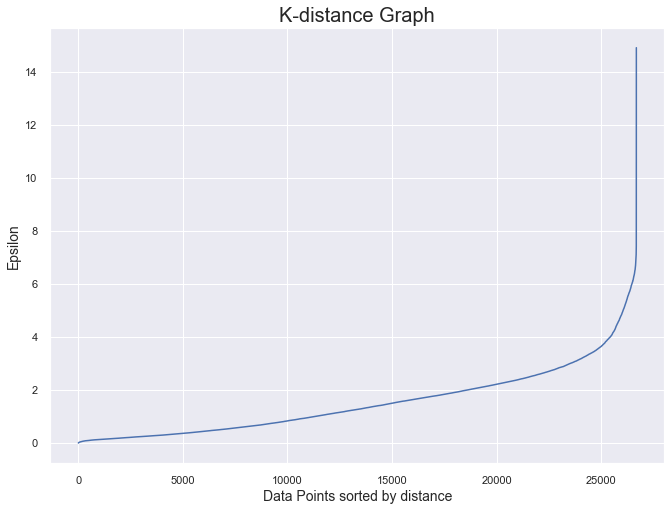

In [103]:
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Optimal epsilon appears somewhere around 4.

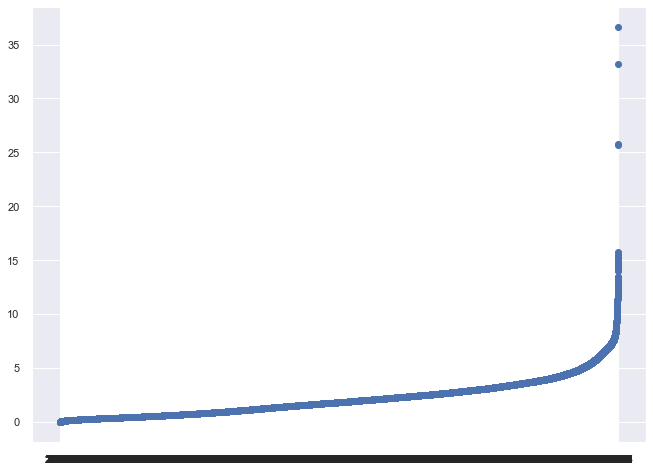

In [104]:
# Look at the minimum distance between points and plot to get an idea of the ideal eps range
df2 = pd.DataFrame(columns = ['index','distance'])
for i in range(0,len(full_cluster_scaled)-1):
    dist = np.linalg.norm(full_cluster_scaled.iloc[i]-full_cluster_scaled.iloc[i+1])
    df2 = df2.append({"index": str(i), 'distance': dist}, ignore_index=True)
    
df2 = df2.sort_values(by=['distance'])
plt.scatter(df2['index'],df2['distance'])
plt.show()

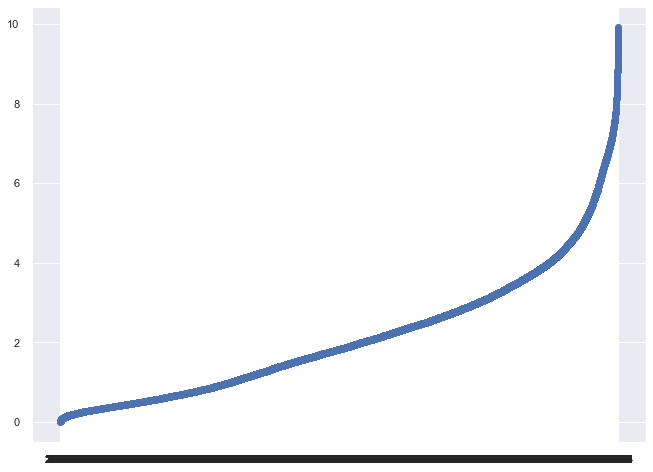

In [105]:
df3 = df2[df2['distance'] < 10]
df3 = df3.sort_values(by=['distance'])
plt.scatter(df3['index'],df3['distance'])
plt.show()

The elbow appears to be somewhere around 4.

23373


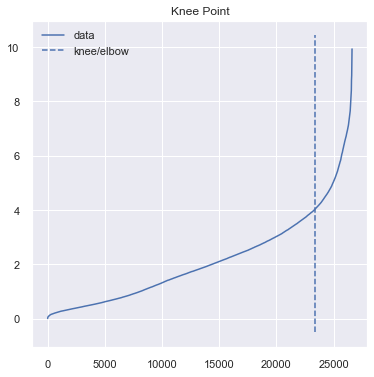

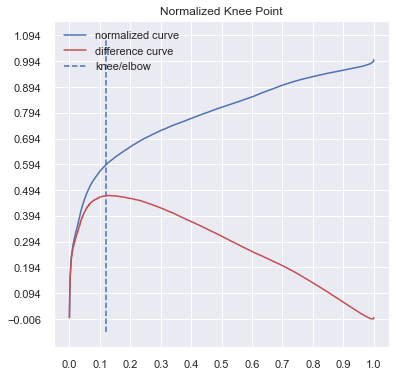

In [106]:
# Use Kneed library to find elbow/knee
# The sensitivity parameter has been adjusted here to account for more flat points before reaching the elbow
kneedle = KneeLocator(list(range(len(df3['distance']))), df3['distance'], S=6.0, curve="convex", direction="increasing")

# Raw data and knee.
kneedle.plot_knee()
print(round(kneedle.elbow, 3))
# Normalized data, normalized knee, and normalized distance curve.
kneedle.plot_knee_normalized()

In [107]:
df3['distance'].iloc[23373]

4.026282926932488

According to KneeLocator the optimal value is 4.026 after tuning the sensitivity parameter.

In [383]:
eps = 4.026282926932488

In [92]:
# StandardScaler
# Use the Silhouette distance to test ideal eps values
range_eps = []
for i in range_eps:
    print('Eps value ',str(i))
    db = DBSCAN(eps=i, min_samples=5, n_jobs=5).fit(full_cluster_scaled_drop)
#     core_samples_mask = np.zeros(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    print(set(labels))
    silhouette_avg = silhouette_score(full_cluster_scaled_drop, labels)
    print('For eps value ', str(i), labels,'The average silhouette score is: ', silhouette_avg)

# full_cluster_scaled
# Eps value  1
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, -1}
# For eps value  1 [  0   0   0 ... 273 273 273] The average silhouette score is:  -0.181860241732571
# Eps value  1.5
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, -1}
# For eps value  1.5 [  0   0   0 ... 148 148 148] The average silhouette score is:  -0.2777961673558467
# Eps value  2
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, -1}
# For eps value  2 [0 0 0 ... 0 0 0] The average silhouette score is:  -0.16267694591598586
# Eps value  2.5
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, -1}
# For eps value  2.5 [0 0 0 ... 0 0 0] The average silhouette score is:  -0.05389842883530773
# Eps value  3
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}
# For eps value  3 [0 0 0 ... 0 0 0] The average silhouette score is:  0.1382541064655948
# Eps value  3.5
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}
# For eps value  3.5 [0 0 0 ... 0 0 0] The average silhouette score is:  0.17777715374878864
# Eps value  4
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
# For eps value  4 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3028375340083086
# Eps value  4.5
# {0, 1, 2, -1}
# For eps value  4.5 [0 0 0 ... 0 0 0] The average silhouette score is:  0.37570021913947993
# Eps value  5
# {0, 1, -1}
# For eps value  5 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3847211410289699
# Eps value  6
# {0, 1, -1}
# For eps value  6 [0 0 0 ... 0 0 0] The average silhouette score is:  0.4557398954684398
# Eps value  7
# {0, -1}
# For eps value  7 [0 0 0 ... 0 0 0] The average silhouette score is:  0.6547981740426814
# Eps value  8
# {0, -1}
# For eps value  8 [0 0 0 ... 0 0 0] The average silhouette score is:  0.8142696081476095
# Eps value  3.6
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
# For eps value  3.6 [0 0 0 ... 0 0 0] The average silhouette score is:  0.18717716545209465
# Eps value  3.7
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
# For eps value  3.7 [0 0 0 ... 0 0 0] The average silhouette score is:  0.19137687184793767
# Eps value  3.8
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
# For eps value  3.8 [0 0 0 ... 0 0 0] The average silhouette score is:  0.26152930287467663
# Eps value  3.9
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
# For eps value  3.9 [0 0 0 ... 0 0 0] The average silhouette score is:  0.26593328827304713
# Eps value  3.95
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
# For eps value  3.95 [0 0 0 ... 0 0 0] The average silhouette score is:  0.26759588899822906
# Eps value  4
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
# For eps value  4 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3028375340083086
# Eps value  4.026
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
# For eps value  4.026 [0 0 0 ... 0 0 0] The average silhouette score is:  0.30293272287698364
# Eps value  4.05
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
# For eps value  4.05 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3014868909137804
# Eps value  4.1
# {0, 1, 2, 3, 4, 5, 6, 7, -1}
# For eps value  4.1 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3026826932991585
# Eps value  4.2
# {0, 1, 2, 3, 4, 5, -1}
# For eps value  4.2 [0 0 0 ... 0 0 0] The average silhouette score is:  0.30217515278136176

# trans_df
# Eps value  3.8
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
# For eps value  3.8 [0 0 0 ... 0 0 0] The average silhouette score is:  0.20033421555691594
# Eps value  3.9
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}
# For eps value  3.9 [0 0 0 ... 0 0 0] The average silhouette score is:  0.2898005179542327
# Eps value  4
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}
# For eps value  4 [0 0 0 ... 0 0 0] The average silhouette score is:  0.29450910087780274
# Eps value  4.026
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
# For eps value  4.026 [0 0 0 ... 0 0 0] The average silhouette score is:  0.2939792689805279
# Eps value  4.1
# {0, 1, 2, 3, 4, 5, -1}
# For eps value  4.1 [0 0 0 ... 0 0 0] The average silhouette score is:  0.301234725301615
# Eps value  4.2
# {0, 1, 2, 3, 4, 5, -1}
# For eps value  4.2 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3018065020941893
# Eps value  4.3
# {0, 1, 2, 3, 4, -1}
# For eps value  4.3 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3034765085950059
# Eps value  4.4
# {0, 1, 2, 3, -1}
# For eps value  4.4 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3597992618617769
# Eps value  4.5
# {0, 1, 2, -1}
# For eps value  4.5 [0 0 0 ... 0 0 0] The average silhouette score is:  0.3594017720682496
# Eps value  5
# {0, -1}
# For eps value  5 [0 0 0 ... 0 0 0] The average silhouette score is:  0.39526237041572
# Eps value  6
# {0, -1}
# For eps value  6 [0 0 0 ... 0 0 0] The average silhouette score is:  0.4525181186355558

Eps value  6
{0, 1, -1}
For eps value  6 [0 0 0 ... 0 0 0] The average silhouette score is:  0.4557398954684398


Optimal epsilon value appears confirmed at 4.026. Next step is finding optimal min_samples

In [ ]:
# Test different numbers of min_samples
min_samples = []
for i in min_samples:
    print("min_samples value:",str(i))
    db = DBSCAN(eps=eps, min_samples=i, n_jobs=5).fit(trans_df)
    # Ignoring the label -1 because its for outliers
    labels = set([label for label in db.labels_ if label >= 0])
    print(set(labels))
    print("For min_samples value",str(i),"Total number of clusters are",str(len(labels)))

# full_cluster_scaled
# min_samples value: 2
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
# For min_samples value 2 Total number of clusters are 21
# min_samples value: 3
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
# For min_samples value 3 Total number of clusters are 16
# min_samples value: 4
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
# For min_samples value 4 Total number of clusters are 12
# min_samples value: 5
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
# For min_samples value 5 Total number of clusters are 10
# min_samples value: 6
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 6 Total number of clusters are 7
# min_samples value: 7
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 7 Total number of clusters are 7
# min_samples value: 8
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 8 Total number of clusters are 7
# min_samples value: 9
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 9 Total number of clusters are 7
# min_samples value: 10
# {0, 1, 2, 3, 4, 5, 6, 7}
# For min_samples value 10 Total number of clusters are 8
# min_samples value: 11
# {0, 1, 2, 3, 4}
# For min_samples value 11 Total number of clusters are 5
# min_samples value: 12
# {0, 1, 2, 3, 4}
# For min_samples value 12 Total number of clusters are 5
# min_samples value: 13
# {0, 1, 2, 3}
# For min_samples value 13 Total number of clusters are 4
# min_samples value: 14
# {0, 1, 2, 3, 4, 5}
# For min_samples value 14 Total number of clusters are 6
# min_samples value: 15
# {0, 1, 2, 3}
# For min_samples value 15 Total number of clusters are 4
# min_samples value: 20
# {0, 1, 2}
# For min_samples value 20 Total number of clusters are 3

# trans_df
# min_samples value: 2
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
# For min_samples value 2 Total number of clusters are 20
# min_samples value: 3
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
# For min_samples value 3 Total number of clusters are 16
# min_samples value: 4
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
# For min_samples value 4 Total number of clusters are 11
# min_samples value: 5
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
# For min_samples value 5 Total number of clusters are 10
# min_samples value: 6
# {0, 1, 2, 3, 4, 5}
# For min_samples value 6 Total number of clusters are 6
# min_samples value: 7
# {0, 1, 2, 3, 4, 5}
# For min_samples value 7 Total number of clusters are 6
# min_samples value: 8
# {0, 1, 2, 3, 4, 5}
# For min_samples value 8 Total number of clusters are 6
# min_samples value: 9
# {0, 1, 2, 3, 4, 5}
# For min_samples value 9 Total number of clusters are 6
# min_samples value: 10
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 10 Total number of clusters are 7
# min_samples value: 11
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 11 Total number of clusters are 7
# min_samples value: 12
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 12 Total number of clusters are 7
# min_samples value: 13
# {0, 1, 2, 3, 4, 5, 6}
# For min_samples value 13 Total number of clusters are 7
# min_samples value: 14
# {0, 1, 2, 3, 4, 5}
# For min_samples value 14 Total number of clusters are 6
# min_samples value: 15
# {0, 1, 2, 3}
# For min_samples value 15 Total number of clusters are 4
# min_samples value: 16
# {0, 1, 2, 3}
# For min_samples value 16 Total number of clusters are 4
# min_samples value: 17
# {0, 1, 2, 3}
# For min_samples value 17 Total number of clusters are 4
# min_samples value: 18
# {0, 1, 2, 3}
# For min_samples value 18 Total number of clusters are 4
# min_samples value: 19
# {0, 1, 2}
# For min_samples value 19 Total number of clusters are 3
# min_samples value: 20
# {0, 1, 2}
# For min_samples value 20 Total number of clusters are 3

If we judge by the Silhouette/KMeans scores we would select 5 for min_samples. Since this dataset is already labeled and we know there are 6 classes, there are a few potential options and we can aim to minimize noise.

In [386]:
# Compute final DBSCAN with eps and min samples at 5
db = DBSCAN(eps=eps, min_samples=5, n_jobs=5).fit(full_cluster_scaled)
labels = db.labels_

n_clusters_ = len(set(labels))
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# full_cluster_scaled_5
# Estimated number of clusters: 11
# Estimated number of noise points: 1267
# full_cluster_scaled_10
# Estimated number of clusters: 9
# Estimated number of noise points: 1320
# full_cluster_scaled_14
# Estimated number of clusters: 7
# Estimated number of noise points: 1374

# trans_df_5
# Estimated number of clusters: 11
# Estimated number of noise points: 1313
# trans_df_7
# Estimated number of clusters: 7
# Estimated number of noise points: 1345
# trans_df_14
# Estimated number of clusters: 7
# Estimated number of noise points: 1434

Estimated number of clusters: 11
Estimated number of noise points: 1267


In [387]:
pd.set_option('display.max_rows', 500)
label_comp = full_df.copy()
label_comp['dbscan'] = labels
label_comp.groupby(['dbscan','category_label'])['dbscan'].count()

dbscan  category_label       
-1      CsI                          3
        Pure Inorg. Standards      299
        Pure Mineral               276
        Pure Org. Standards         44
        Real world sample          625
        Spiked Minerals             20
 0      CsI                       4791
        Pure Inorg. Standards     2079
        Pure Mineral             10778
        Pure Org. Standards       1050
        Real world sample         5830
        Spiked Minerals            727
 1      Pure Inorg. Standards       10
 2      Pure Inorg. Standards       10
 3      Pure Inorg. Standards       36
 4      Pure Inorg. Standards       19
 5      Pure Inorg. Standards        5
 6      Pure Inorg. Standards       18
 7      Pure Inorg. Standards        5
 8      Real world sample            7
 9      Pure Inorg. Standards       50
        Pure Mineral                 3
Name: dbscan, dtype: int64

In [388]:
print(pd.DataFrame(label_comp.groupby(['dbscan','sample_label'])['dbscan'].count()))
pd.reset_option('display.max_rows')

                                         dbscan
dbscan sample_label                            
-1     Anhydrite                              1
       Atacama                               14
       Au-Coated CsI                          1
       CaSiO3                                18
       Calcite                               11
       CsI                                    2
       DGDG                                  13
       FeSO4.7H2O                            15
       Forsterite                            38
       Fspat1 powder                          5
       Glu in Mont                            6
       Gly+Ala+Ser mixture + CHCA            12
       Hematite                              72
       Hopane                                 3
       MGDG                                  12
       Magadi                                13
       Mg Perc. in Mont                       1
       Mg2SiO4                                8
       MnSO4                            

In [101]:
print("Final Silhoette Coefficient: %0.3f" % silhouette_score(full_cluster_scaled, labels))

Final Silhoette Coefficient: 0.303


After testing a few different values that fit the described process for tuning DBSCAN hyperparameters the results are not satisfying. One large clusters emerges that contain the overwhelming majority of observations despite our knowledge that there are 6 different classes. Additionally the final Silhouette Score is indicative of non-optimally split data.

DBSCAN excels at separating high density clusters from low density clusters but struggles with clusters of similar density, which could the issue here. It also can struggle with high dimensional data and that is likely a factor.

The section below searches over a range of combinations of epsilon and minimum sample values and displays the results with heatmaps.

In [25]:
# eps_values = np.arange(.01,1000) # eps values to be investigated
# min_samples = np.arange(2,1000,500) # min_samples values to be investigated
eps_values = [3,3.9,4,4.026,4.2,4.5,5]
min_samples = [4,5,6,7,8,9,10,11,12,13]
DBSCAN_params = list(product(eps_values, min_samples))

In [26]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1],n_jobs=5).fit(full_cluster_scaled)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(full_cluster_scaled, DBS_clustering.labels_))

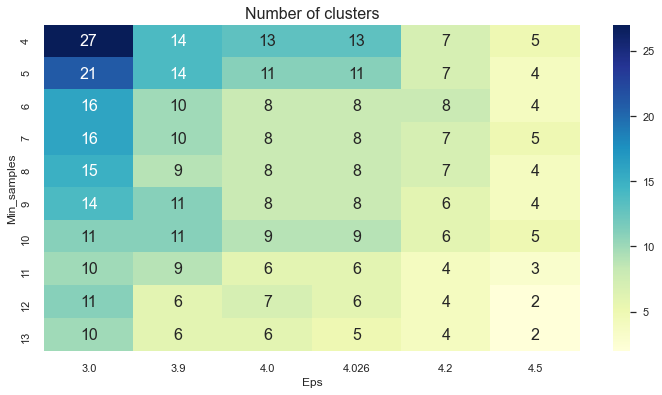

In [27]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters',fontsize=16)
plt.show()

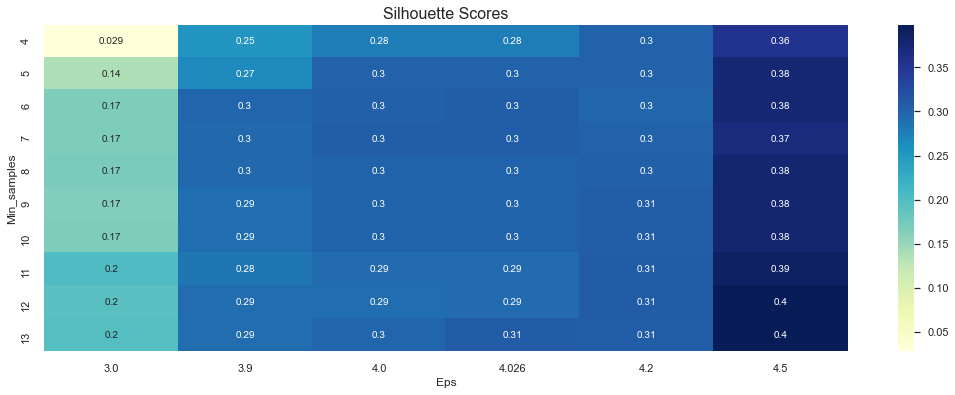

In [28]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
ax.set_title('Silhouette Scores',fontsize=16)
plt.show()

Heatmaps are great at visualizing but this one is particularly computationally expensive.

<h3>SciPy Hierarchical Clustering</h3>

In [18]:
# Use Cophenetic Coefficient to determine linkage method
c_list = []
methods = ['ward','single','complete','average','weighted','centroid','median']
for method in methods:
    Z = shc.linkage(full_cluster_scaled, method)
    c, coph_dists = cophenet(Z, pdist(full_cluster_scaled))
    c_list.append(c)

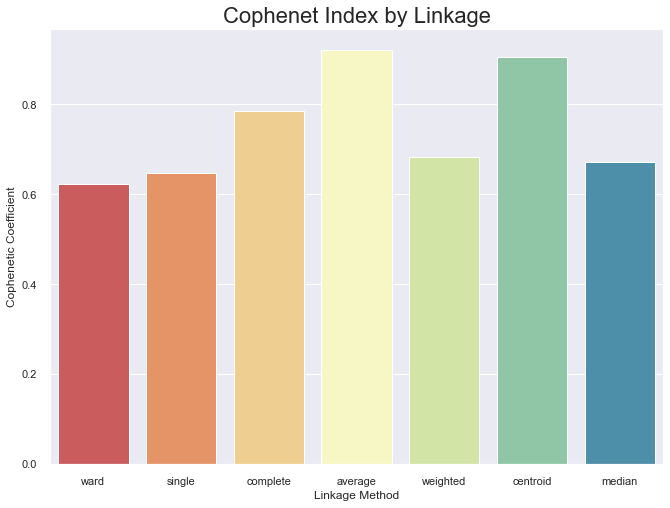

In [43]:
palette = 'Spectral'
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x=methods,y=c_list,palette=palette)
ax.set(ylabel="Cophenetic Coefficient")
ax.set(xlabel='Linkage Method')
ax.set_title('Cophenet Index by Linkage',fontsize=22)
plt.show()

In [44]:
# Compute dendrogram using selected linkage method
Z_final = shc.linkage(full_cluster_scaled, 'average')

In [47]:
# Source: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Selecting-a-Distance-Cut-Off-aka-Determining-the-Number-of-Clusters
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = shc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)',fontsize=22)
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

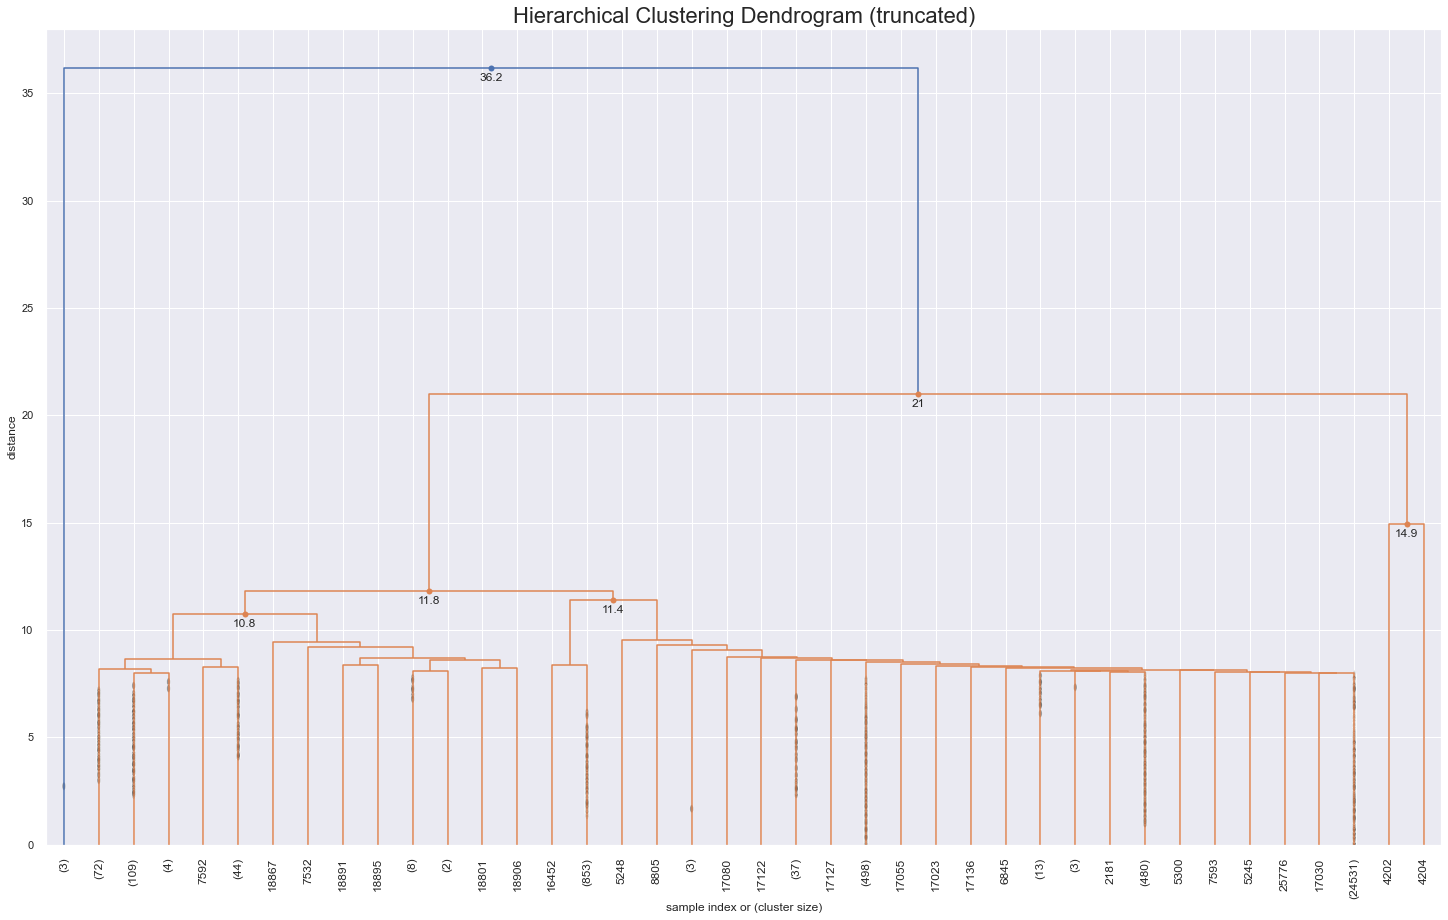

In [48]:
plt.figure(figsize=(25, 15))
fancy_dendrogram(
    Z_final,
    truncate_mode='lastp',
    p=40,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

Interpreting a dendrogram is a bit subjective but we can immediately see the DBSCAN results - one large orange cluster with left blue as outliers/noise. It becomes harder to make a strong claim about cluster size anywhere below that level. A cutoff line can be drawn to create 2 - 6 clusters that ignores the noise but anything further is harder to jusitfy.

### t-SNE

In [49]:
time_start = time.time()
tsne_full = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=400, n_jobs=5)
tsne_results_full = tsne_full.fit_transform(full_cluster_scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26685 samples in 15.255s...
[t-SNE] Computed neighbors for 26685 samples in 283.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26685
[t-SNE] Computed conditional probabilities for sample 2000 / 26685
[t-SNE] Computed conditional probabilities for sample 3000 / 26685
[t-SNE] Computed conditional probabilities for sample 4000 / 26685
[t-SNE] Computed conditional probabilities for sample 5000 / 26685
[t-SNE] Computed conditional probabilities for sample 6000 / 26685
[t-SNE] Computed conditional probabilities for sample 7000 / 26685
[t-SNE] Computed conditional probabilities for sample 8000 / 26685
[t-SNE] Computed conditional probabilities for sample 9000 / 26685
[t-SNE] Computed conditional probabilities for sample 10000 / 26685
[t-SNE] Computed conditional probabilities for sample 11000 / 26685
[t-SNE] Computed conditional probabilities for sample 12000 / 26685
[t-SNE] Computed conditional probabilities for 

In [50]:
time_start = time.time()
tsne_trans = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=350, n_jobs=5)
tsne_results_trans = tsne_trans.fit_transform(trans_df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26685 samples in 17.726s...
[t-SNE] Computed neighbors for 26685 samples in 281.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26685
[t-SNE] Computed conditional probabilities for sample 2000 / 26685
[t-SNE] Computed conditional probabilities for sample 3000 / 26685
[t-SNE] Computed conditional probabilities for sample 4000 / 26685
[t-SNE] Computed conditional probabilities for sample 5000 / 26685
[t-SNE] Computed conditional probabilities for sample 6000 / 26685
[t-SNE] Computed conditional probabilities for sample 7000 / 26685
[t-SNE] Computed conditional probabilities for sample 8000 / 26685
[t-SNE] Computed conditional probabilities for sample 9000 / 26685
[t-SNE] Computed conditional probabilities for sample 10000 / 26685
[t-SNE] Computed conditional probabilities for sample 11000 / 26685
[t-SNE] Computed conditional probabilities for sample 12000 / 26685
[t-SNE] Computed conditional probabilities for 

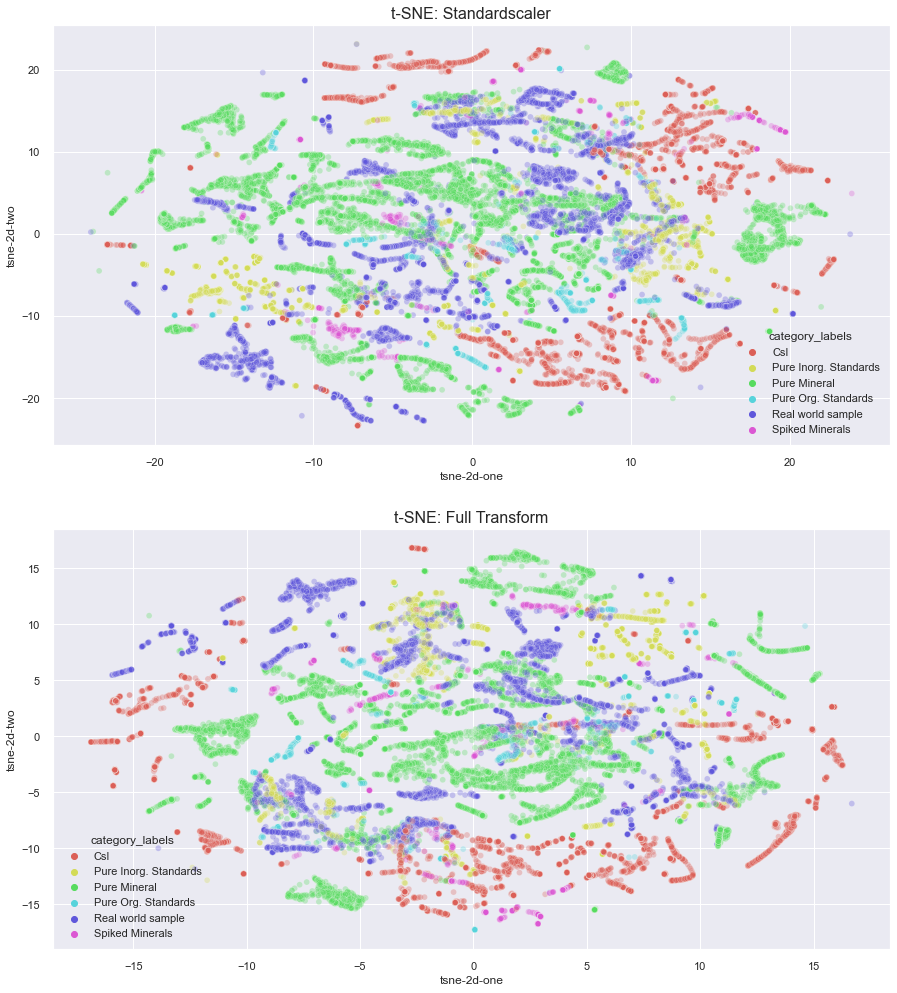

In [114]:
fig, axes = plt.subplots(2,1, figsize=(15,17))

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results_full[:,0]
df_subset['tsne-2d-two'] = tsne_results_full[:,1]
df_subset['category_labels'] = full_df['category_label']
df_subset['sample_labels'] = full_df['sample_label']

ax_1 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_labels",
    palette=sns.color_palette("hls", 6),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=axes[0]
)
ax_1.set_title('t-SNE: Standardscaler',fontsize=16)

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results_trans[:,0]
df_subset['tsne-2d-two'] = tsne_results_trans[:,1]
df_subset['category_labels'] = full_df['category_label']
df_subset['sample_labels'] = full_df['sample_label']

ax_2 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_labels",
    palette=sns.color_palette("hls", 6),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=axes[1]
)
ax_2.set_title("t-SNE: Full Transform",fontsize=16)

plt.show()

A surprising amount of overlap is visible throughout, in both dense and less dense areas. There also is no clear global separation between classes despite some strong local groupings. Transforming the data did not appear helpful for visualizing from two components.

### PCA

In [62]:
for comp in [10,25,50,75,100,125,175,200,250]:
    pca = PCA(n_components=comp)
    pca_result = pca.fit_transform(full_cluster_scaled)
    print('Cumulative explained variation for',comp,'principal components: {:.4}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 10 principal components: 0.7187
Cumulative explained variation for 25 principal components: 0.7996
Cumulative explained variation for 50 principal components: 0.8365
Cumulative explained variation for 75 principal components: 0.8557
Cumulative explained variation for 100 principal components: 0.8694
Cumulative explained variation for 125 principal components: 0.8807
Cumulative explained variation for 175 principal components: 0.8996
Cumulative explained variation for 200 principal components: 0.9077
Cumulative explained variation for 250 principal components: 0.9211


In [63]:
pca = PCA(n_components=175)
pca_result = pca.fit_transform(full_cluster_scaled)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=400, n_jobs=5)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 26685 samples in 0.997s...
[t-SNE] Computed neighbors for 26685 samples in 24.487s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26685
[t-SNE] Computed conditional probabilities for sample 2000 / 26685
[t-SNE] Computed conditional probabilities for sample 3000 / 26685
[t-SNE] Computed conditional probabilities for sample 4000 / 26685
[t-SNE] Computed conditional probabilities for sample 5000 / 26685
[t-SNE] Computed conditional probabilities for sample 6000 / 26685
[t-SNE] Computed conditional probabilities for sample 7000 / 26685
[t-SNE] Computed conditional probabilities for sample 8000 / 26685
[t-SNE] Computed conditional probabilities for sample 9000 / 26685
[t-SNE] Computed conditional probabilities for sample 10000 / 26685
[t-SNE] Computed conditional probabilities for sample 11000 / 26685
[t-SNE] Computed conditional probabilities for sample 12000 / 26685
[t-SNE] Computed conditional probabilities for s

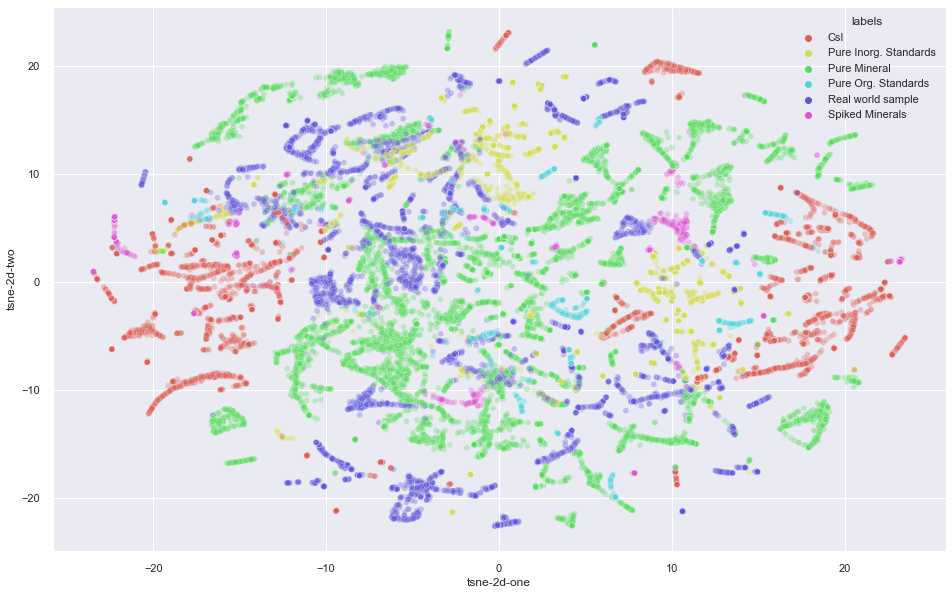

In [64]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['labels'] = full_df['category_label']
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="labels",
    palette=sns.color_palette("hls", 6),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.show()

Relatively better separation compared to t-SNE output but still more overlap than preferable. This indicates the data is quite complex and describing it with only two dimensions isn't enough to separate clusters.

# Model <a name="modeling"></a>

The two main ways of dealing with imbalanced data are changing the data or changing the performance metric and/or the weight of individual data points. The first section will run baseline models without adjusting the data or model for class imbalance. The next section will analyze the effect of modifying the training data and the final section will analyze adjusting algorithms.

In [375]:
# Encode target classes
label_encoder = preprocessing.LabelEncoder()
y_train_cat = label_encoder.fit_transform(full_df['category_label'])
# y_train_sam = label_encoder.fit_transform(full_df['sample_label'])

In [376]:
target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("\n".join("{}\t{}".format(k, v) for k, v in target_mapping.items()))

In [377]:
# Split dataset into training and test sets
# This isn't strictly necessary given the use of cross validation but I am suspicious of this dataset
validation_size = 0.1
seed = 9
# Change target to sample_label if desired
X_train, X_test, y_train, y_test = train_test_split(full_cluster_scaled, y_train_cat, test_size=validation_size, stratify=y_train_cat, random_state=seed)

In [378]:
# Set variables
num_folds = 10
seed = 7
n_cores = 5
scoring = ['accuracy','f1_macro','f1_weighted','precision_macro','precision_weighted']

### Baseline: Non-ensemble Methods

In [379]:
base_non_en_models = []
base_non_en_models.append(('LR', LogisticRegression()))
base_non_en_models.append(('LDA', LinearDiscriminantAnalysis()))
base_non_en_models.append(('KNN', KNeighborsClassifier()))
base_non_en_models.append(('CART', DecisionTreeClassifier()))
base_non_en_models.append(('NB', GaussianNB()))
base_non_en_models.append(('SVM', SVC()))

In [380]:
non_ensemble_base_df = evaluate_models(base_non_en_models, X_train, y_train, num_folds, scoring, n_cores)

In [381]:
model_score_display(non_ensemble_base_df,'vlag')

Model,LR,LDA,KNN,CART,NB,SVM
fit_time,35.797,39.102,13.970,13.012,2.331,369.129
score_time,0.123,0.105,54.466,0.046,0.562,40.801
test_accuracy,0.912,0.877,0.947,0.894,0.474,0.961
test_f1_macro,0.885,0.824,0.922,0.839,0.393,0.941
test_f1_weighted,0.911,0.876,0.947,0.894,0.496,0.961
test_precision_macro,0.902,0.835,0.931,0.846,0.510,0.972
test_precision_weighted,0.912,0.877,0.947,0.894,0.619,0.962
train_accuracy,0.945,0.908,0.961,1.000,0.478,0.978
train_f1_macro,0.935,0.870,0.944,1.000,0.399,0.966
train_f1_weighted,0.945,0.907,0.961,1.000,0.501,0.978


Overall strong performance with basic models and without any tuning which lends suspicion that this is too good to be true. Leading hypotheses are that data leakage has occurred somewhere in preprocessing or that this dataset is somehow bad, either a lack of diversity/variance, too small, etc.

The only poor performing classifier was Naive Bayes, most likely due to the underlying assumption that all features are independent, which is not the case here. Additionally the Decision Tree has memorized the training data which is another indicator of a lack of diversity in the data.

### Baseline: Ensemble Methods

In [369]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
# ensembles.append(('HGB', HistGradientBoostingClassifier()))
ensembles.append(('LGB', lgb.LGBMClassifier()))
# ensembles.append(('XGB', xgb.XGBClassifier()))

In [370]:
ensemble_base_df = evaluate_models(ensembles, X_train, y_train, num_folds, scoring, n_cores)

In [371]:
model_score_display(ensemble_base_df,'vlag')

Model,AB,GBM,RF,ET,LGB
fit_time,52.118,981.438,25.080,33.174,188.771
score_time,1.147,0.107,0.158,0.225,0.225
test_accuracy,0.722,0.919,0.927,0.935,0.966
test_f1_macro,0.577,0.877,0.856,0.876,0.948
test_f1_weighted,0.714,0.917,0.923,0.932,0.966
test_precision_macro,0.606,0.931,0.957,0.963,0.972
test_precision_weighted,0.718,0.920,0.930,0.937,0.966
train_accuracy,0.726,0.947,1.000,1.000,0.998
train_f1_macro,0.586,0.929,1.000,1.000,0.999
train_f1_weighted,0.718,0.946,1.000,1.000,0.998


Similar to the non-ensemble methods we see strong overall performance stemming from overfitting. The AdaBoost Classifier is not prone to overfitting but is sensitive to noise and that most likely is what happened here. 

# Imbalanced Data Augmentation Methods

### SMOTE (Synthetic Minority Oversampling TEchnique)

One approach to working with imbalanced data is to oversample the minority class with synthesized data. SMOTE works by selecting examples close together in the feature space, connecting them with a line and drawing new samples at a point along the line. One downside of this approach is that the synthetic examples are created without considering the majority class which can result in ambiguous examples if there is overlap between classes. Oversampling tends to outperform under sampling but it increases the likelihood of overfitting and that was already a concern.

In [364]:
counter = Counter(full_df['category_label'])
print('Full data set')
counter

Full data set


Counter({'CsI': 4794,
         'Pure Inorg. Standards': 2531,
         'Pure Mineral': 11057,
         'Pure Org. Standards': 1094,
         'Real world sample': 6462,
         'Spiked Minerals': 747})

Class=4, n=5816 (24.217%)
Class=2, n=9951 (41.435%)
Class=0, n=4314 (17.963%)
Class=3, n=985 (4.101%)
Class=5, n=672 (2.798%)
Class=1, n=2278 (9.485%)


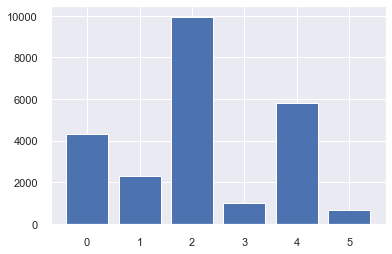

In [365]:
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Class=4, n=9951 (16.667%)
Class=2, n=9951 (16.667%)
Class=0, n=9951 (16.667%)
Class=3, n=9951 (16.667%)
Class=5, n=9951 (16.667%)
Class=1, n=9951 (16.667%)


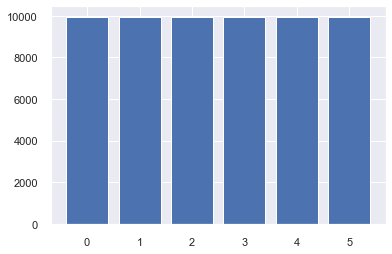

In [366]:
# transform the dataset
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y_smote)
for k,v in counter.items():
    per = v / len(y_smote) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [367]:
non_ensemble_smote_df = evaluate_models(base_non_en_models, X_smote, y_smote, num_folds, scoring, n_cores)

In [372]:
ensemble_smote_df = evaluate_models(ensembles, X_smote, y_smote, num_folds, scoring, n_cores)

In [373]:
model_score_display(non_ensemble_smote_df,'vlag')

Model,LR,LDA,KNN,CART,NB,SVM
fit_time,105.612,122.289,53.064,37.324,8.273,1070.626
score_time,0.393,0.564,152.268,0.083,1.589,150.786
test_accuracy,0.951,0.904,0.979,0.946,0.501,0.990
test_f1_macro,0.950,0.904,0.979,0.945,0.482,0.990
test_f1_weighted,0.950,0.904,0.979,0.945,0.482,0.990
test_precision_macro,0.950,0.906,0.979,0.946,0.563,0.990
test_precision_weighted,0.950,0.906,0.979,0.946,0.563,0.990
train_accuracy,0.962,0.913,0.984,1.000,0.502,0.994
train_f1_macro,0.962,0.913,0.984,1.000,0.483,0.994
train_f1_weighted,0.962,0.913,0.984,1.000,0.483,0.994


In [374]:
model_score_display(ensemble_smote_df,'vlag')

Model,AB,GBM,RF,ET,LGB
fit_time,158.570,3587.770,68.384,78.416,304.235
score_time,2.492,0.323,0.386,0.492,0.670
test_accuracy,0.644,0.943,0.985,0.990,0.988
test_f1_macro,0.639,0.943,0.985,0.990,0.988
test_f1_weighted,0.639,0.943,0.985,0.990,0.988
test_precision_macro,0.649,0.944,0.986,0.990,0.988
test_precision_weighted,0.649,0.944,0.986,0.990,0.988
train_accuracy,0.646,0.953,1.000,1.000,0.998
train_f1_macro,0.640,0.954,1.000,1.000,0.998
train_f1_weighted,0.640,0.954,1.000,1.000,0.998


Balancing the target classes with SMOTE improved performance across the board. Unfortunately this furthers the suspicion that something is wrong. 

# Holdout Test <a name="holdout"></a>

How would a model react to a Pure Org. Standards sample if it hadn't previously seen one? How should it?

In [261]:
holdout_label = 'Pure Org. Standards'

# Get a full copy of all the data
holdout_copy_df = full_df.copy()

# Get all pure org standard rows, then 
holdout_df = holdout_copy_df.loc[holdout_copy_df['category_label'] == holdout_label].drop(['sample_label'],axis=1)
all_else_df = holdout_copy_df.loc[holdout_copy_df['category_label'] != holdout_label].drop(['sample_label'],axis=1)

# Get training from all else, holdout used for prediction
holdout_x = holdout_df.iloc[:,:-1]
holdout_y = holdout_df[holdout_df.columns[-1:]]

all_else_x = all_else_df.iloc[:,:-1]
all_else_y = all_else_df[all_else_df.columns[-1:]]

le = preprocessing.LabelEncoder()
all_else_y = le.fit_transform(all_else_y)
class_map = dict(zip(le.classes_, le.transform(le.classes_)))

# Standardscale holdout_X
standard_scaler = StandardScaler()
holdout_scaled = pd.DataFrame(standard_scaler.fit_transform(holdout_x[['Laser_StdDev','TIC','Max_Bin_Counts','Charge_Control','Laser_Energy','Laser_Shots']]))
h_dum_df = pd.get_dummies(holdout_x['Phase'])
holdout_spectrum_df = pd.DataFrame(holdout_x.iloc[:,:2001].apply(lambda x: x/x.max(), axis=1))
holdout_scaled.index = holdout_spectrum_df.index
holdout_x_scaled = pd.concat([holdout_spectrum_df,holdout_scaled,h_dum_df],axis=1)

# Standardscale all_else_X
standard_scaler = StandardScaler()
all_else_scaled = pd.DataFrame(standard_scaler.fit_transform(all_else_x[['Laser_StdDev','TIC','Max_Bin_Counts','Charge_Control','Laser_Energy','Laser_Shots']]))
a_dum_df = pd.get_dummies(all_else_x['Phase'])
all_else_spectrum_df = pd.DataFrame(all_else_x.iloc[:,:2001].apply(lambda x: x/x.max(), axis=1))
all_else_scaled.index = all_else_spectrum_df.index
all_else_x_scaled = pd.concat([all_else_spectrum_df,all_else_scaled,a_dum_df],axis=1)

In [238]:
# Train best performing model from before on full set less Pure Org. Standards
holdout_model = ExtraTreesClassifier()

# Fit on all data except holdout
holdout_model.fit(all_else_x_scaled,all_else_y)

# Predict on holdout
holdout_pred = holdout_model.predict(holdout_x_scaled)

In [278]:
model_prob = pd.DataFrame(holdout_model.predict_proba(holdout_x_scaled))
model_prob.rename(columns=lambda x: get_key(class_map,x), inplace=True)
model_prob

,CsI,Pure Inorg. Standards,Pure Mineral,Real world sample,Spiked Minerals
0,0.48,0.31,0.10,0.09,0.02
1,0.55,0.26,0.09,0.10,0.00
2,0.49,0.27,0.13,0.10,0.01
3,0.56,0.30,0.10,0.03,0.01
4,0.50,0.25,0.11,0.11,0.03
...,...,...,...,...,...
1089,0.13,0.16,0.32,0.26,0.13
1090,0.14,0.19,0.29,0.22,0.16
1091,0.06,0.16,0.39,0.25,0.14
1092,0.13,0.14,0.31,0.23,0.19


Here we have the results of a thought experiement where we asked a model to make predictions on a class it had never seen. Practically you could threshold the probabilities or use it as one data point in a larger classification workstream. 

It could be interesting to dive into specific cases with guidance from someone who intimately understands the differences and similarities between classes. I expected one class to be overwhelmingly predicted as the most similar but that did not happen.

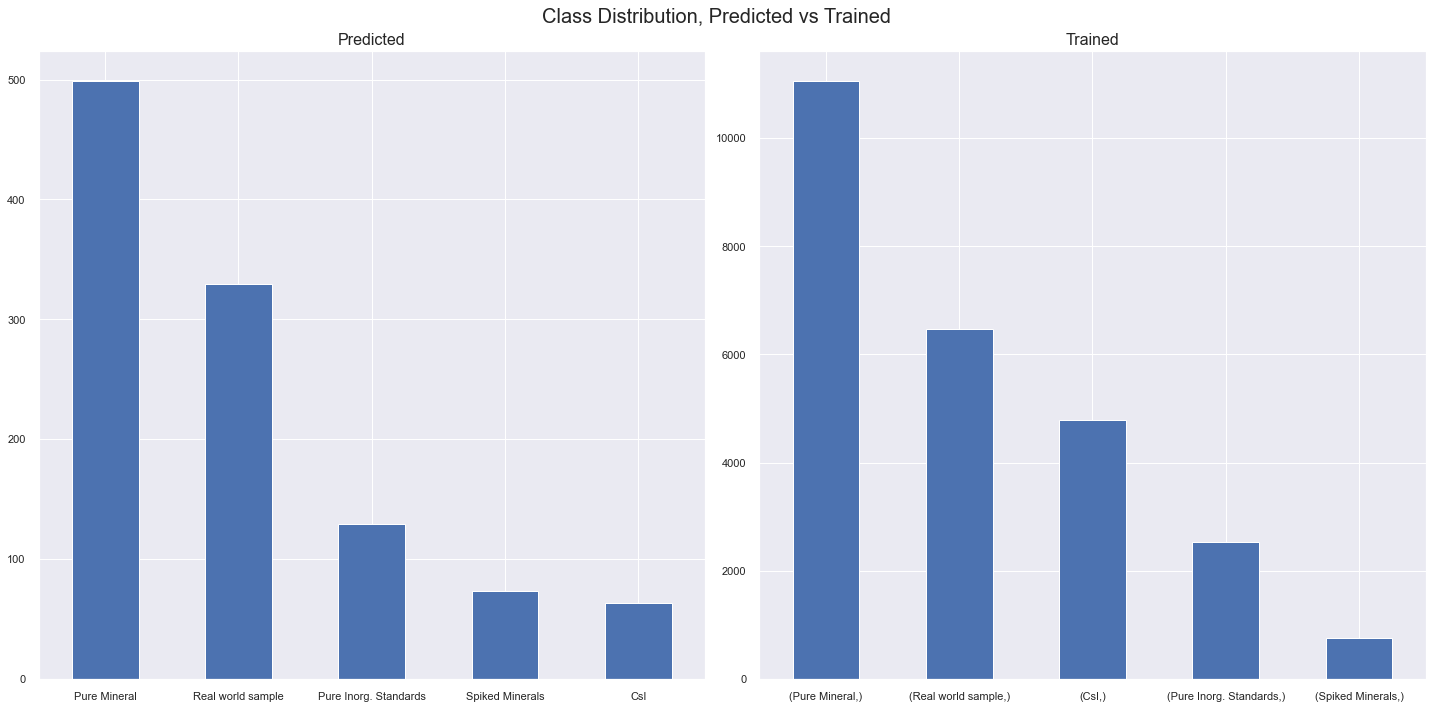

In [363]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
plt_1 = model_prob.sum(axis=0).sort_values(ascending=False).plot(kind='bar',ax=axes[0])
plt_1.set_title("Predicted",fontsize=16)
plt_1.set_xticklabels(plt_1.get_xticklabels(), rotation=0)

plt_2 =pd.DataFrame(map(lambda x: get_key(class_map,x),all_else_y.tolist())).value_counts().plot(kind='bar',ax=axes[1])
plt_2.set_title("Trained",fontsize=16)
plt_2.set_xticklabels(plt_2.get_xticklabels(), rotation=0)
axes[1].set(xlabel=None)

fig.suptitle("Class Distribution, Predicted vs Trained",fontsize=20)
fig.tight_layout()
fig.show()

Open question: Are Pure Org. Standards most similar to Pure Mineral and Real World Sample or did the model just predict in line with the two largest training classes?

Classification algorithms can't classify outside of the trained classes and regression models offer some extrapolation close to the training set but this isn't a regression problem. Another approach is needed to tackle this problem. Obtaining data that more closely resembles a Mars sample is unrealistic so innovation is needed from the modeling side. There are a few neural network concepts that appear promising and include, among others: transfer learning, feature detection/extraction, signal processing, and GANs. Next steps are to explore these concepts in detail as they pertain to identifying signs of life from Martian soil samples.

### [BACK TO TOP](#top)

In [14]:
copy_df = full_df.copy()

In [15]:
copy_df_pm = copy_df[copy_df['category_label']=="Pure Mineral"]

<AxesSubplot:>

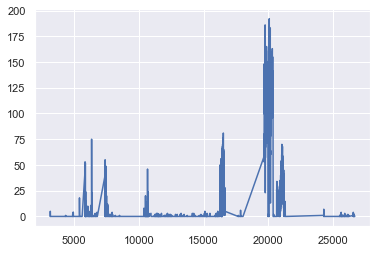

In [27]:
copy_df_pm['555'].plot()